In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


In [40]:
tauc_list = np.linspace(0.0, 0.33, 12)


# 定义参数
sigma = 0.3
N = 1000
g = 5.13
j0 = 0.003
N_E = 800
N_I = 200
thres = 2.1
bias = 1.0


In [41]:
lambda0 = j0 * (N_E - g*N_I)
print('$\\lambda_0$', lambda0)

$\lambda_0$ -0.678


In [42]:
# 高斯积分相关
gaussian_norm = 1 / np.sqrt(np.pi)
gauss_points, gauss_weights = np.polynomial.hermite.hermgauss(300)
gauss_points = gauss_points * np.sqrt(2)

def Phi(mu, delta0, bias, thres):
    integrand = bias + np.tanh(mu + np.sqrt(delta0) * gauss_points - thres)
    return gaussian_norm * np.dot(integrand, gauss_weights)

def derPhi(mu, delta0, thres):
    integrand = 1 / (np.cosh(mu + np.sqrt(delta0) * gauss_points - thres) ** 2)
    return gaussian_norm * np.dot(integrand, gauss_weights)


$\tau^c$ 0.0


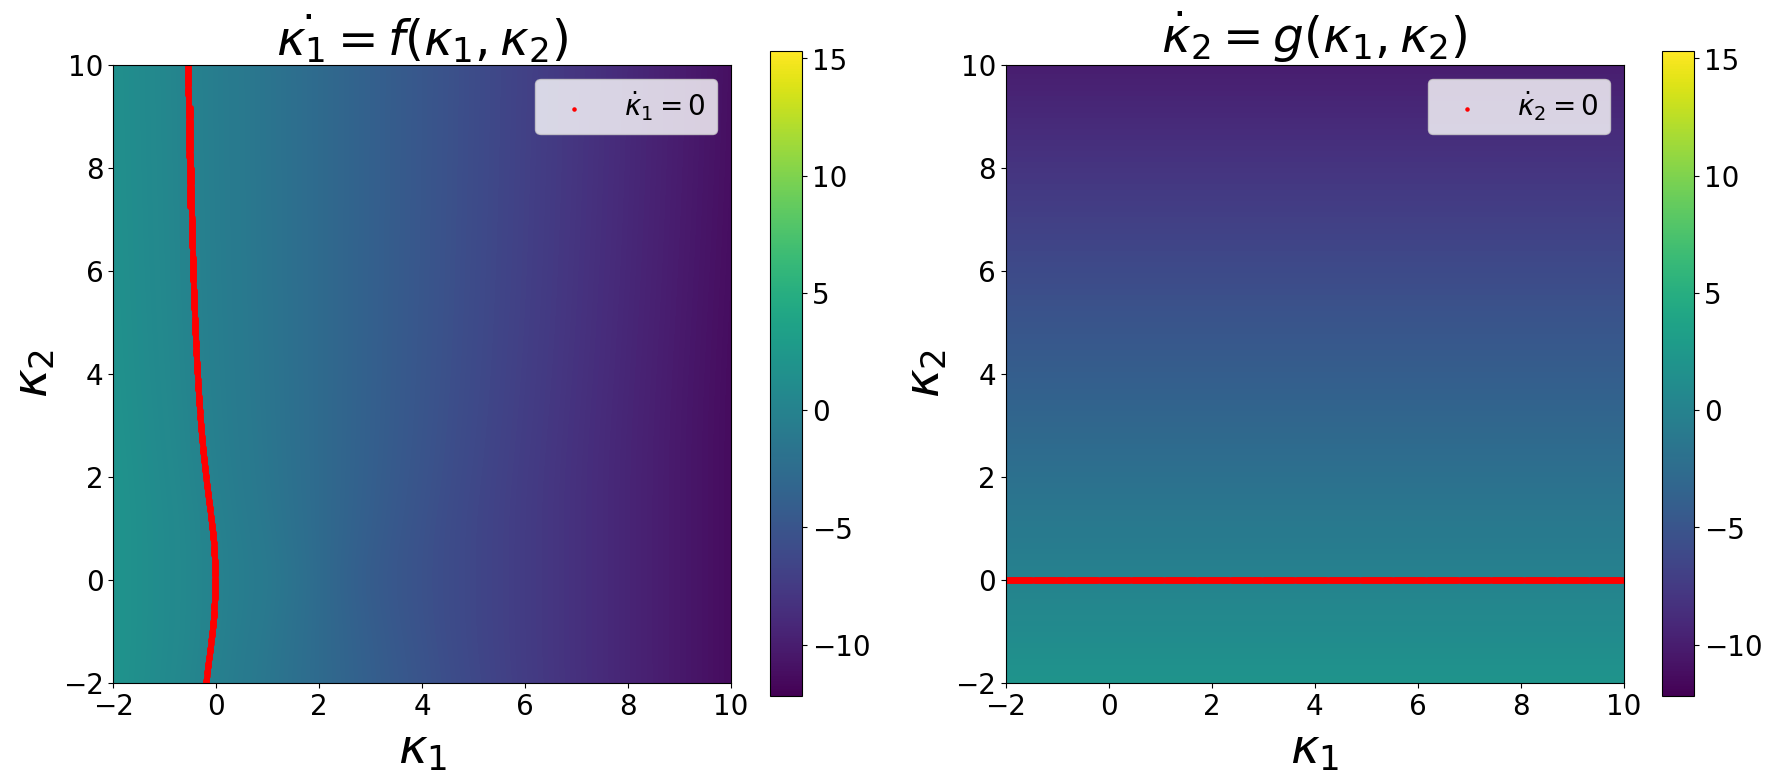

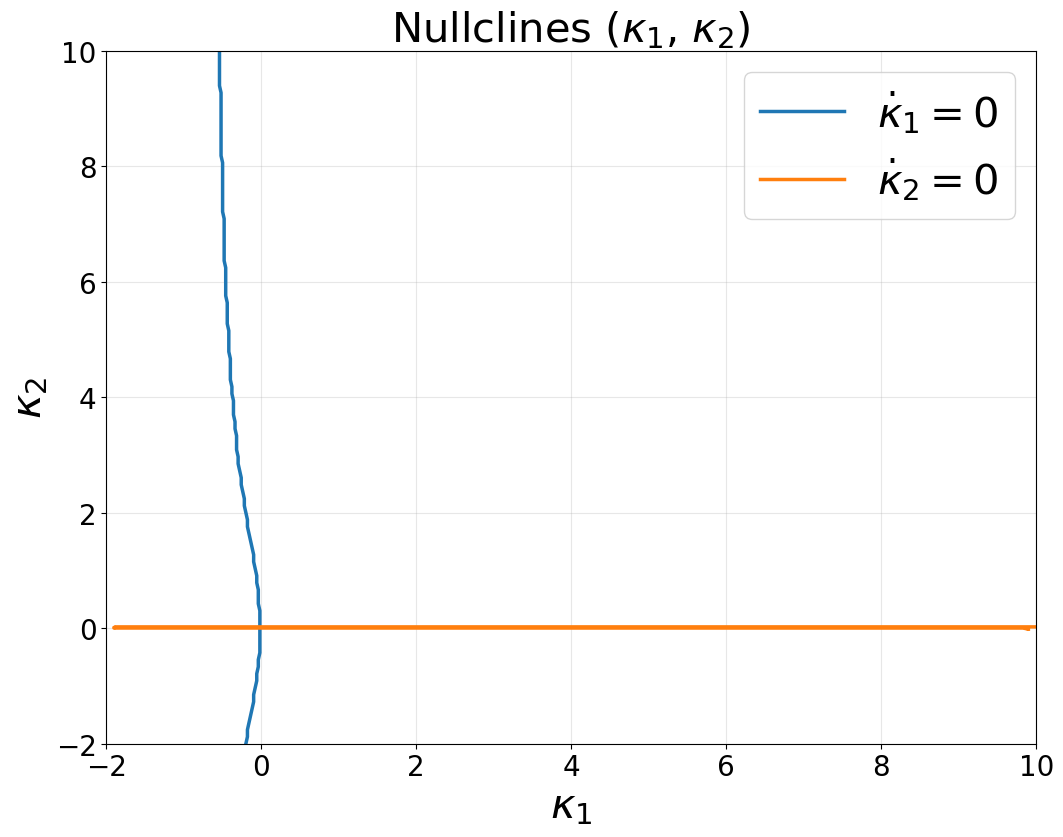

$\tau^c$ 0.030000000000000002


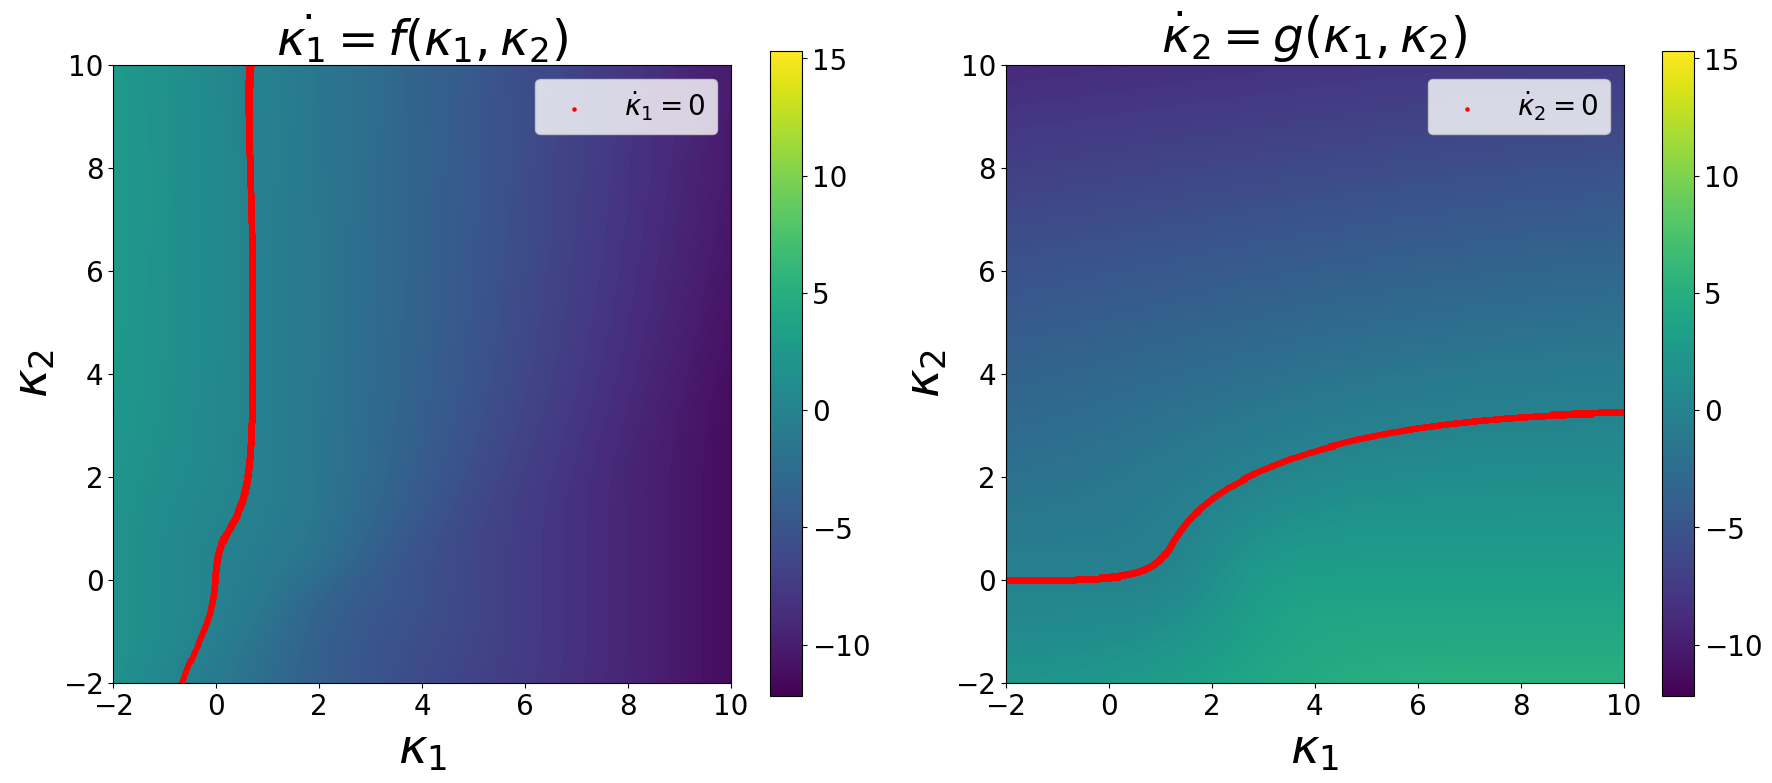

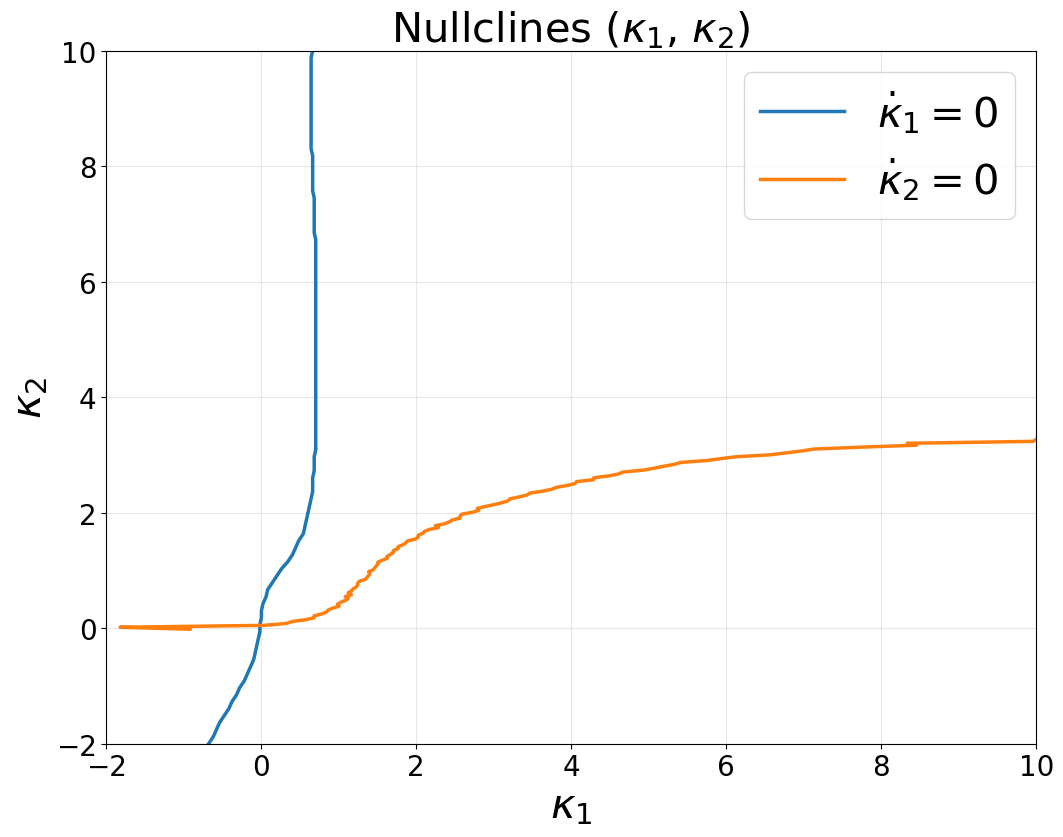

$\tau^c$ 0.060000000000000005


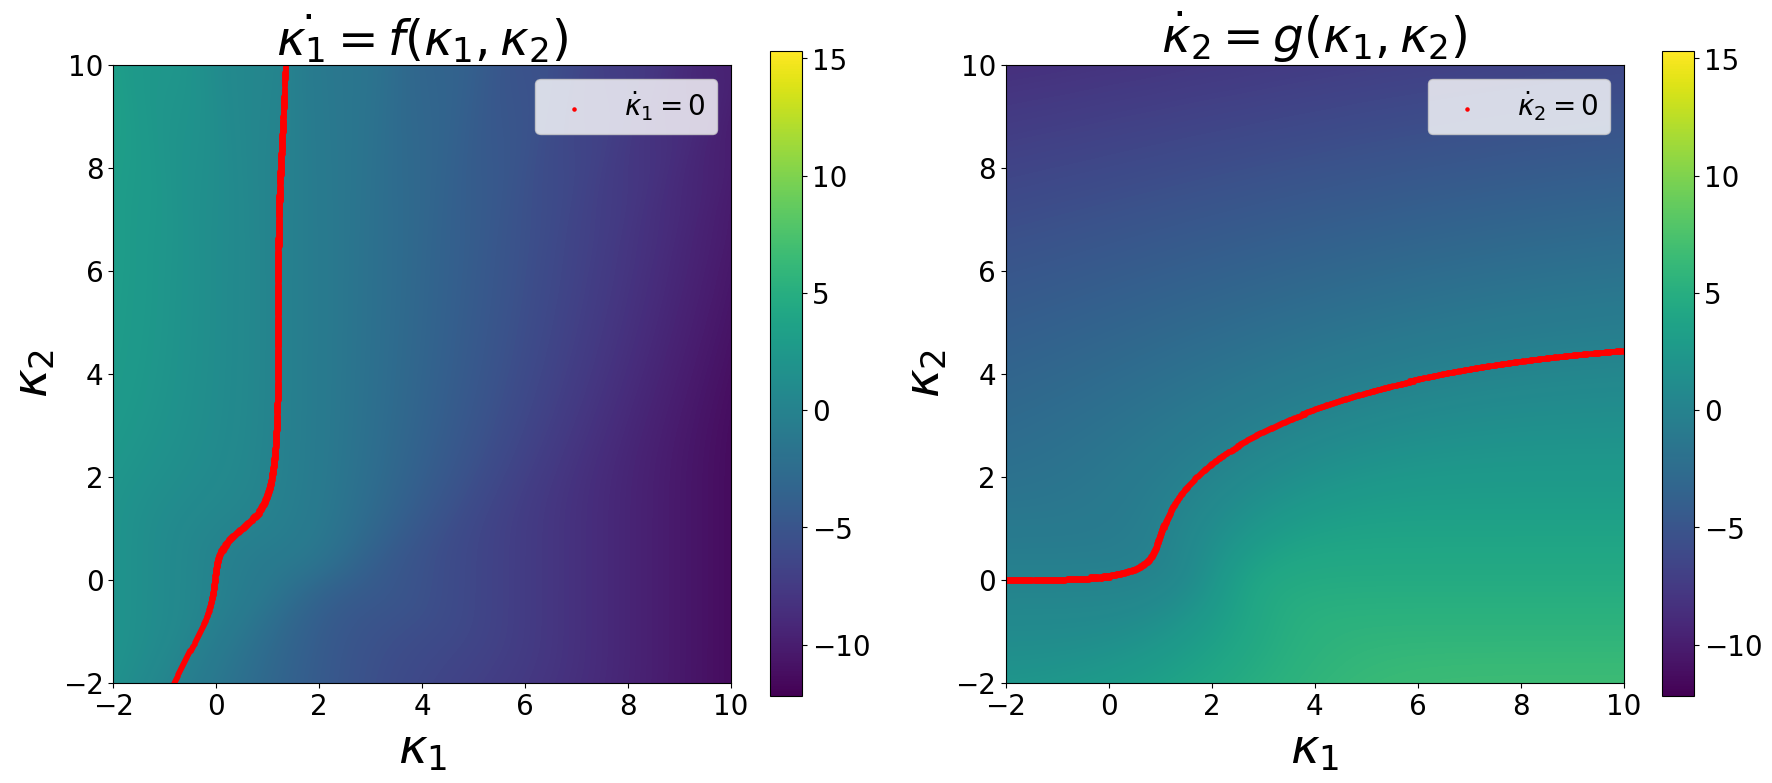

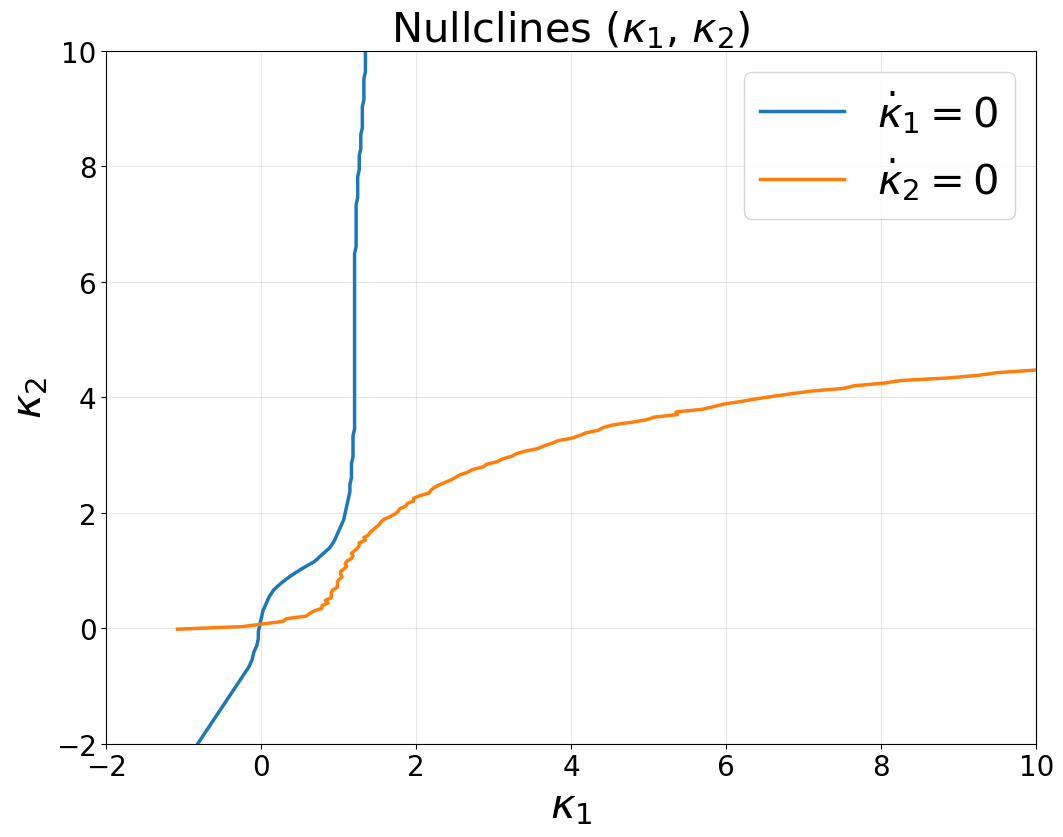

$\tau^c$ 0.09000000000000001


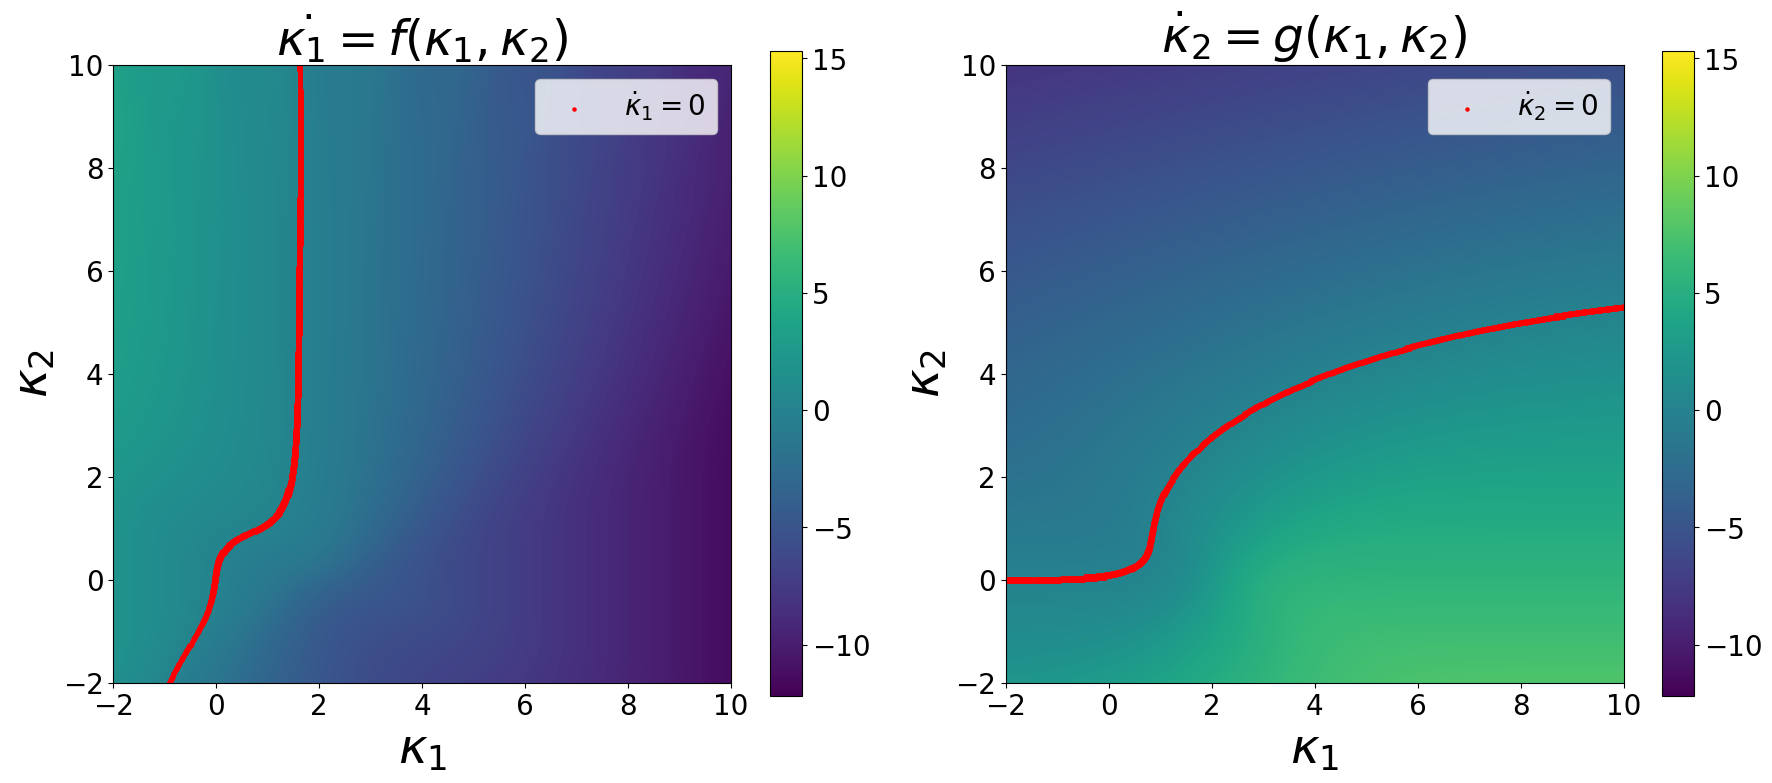

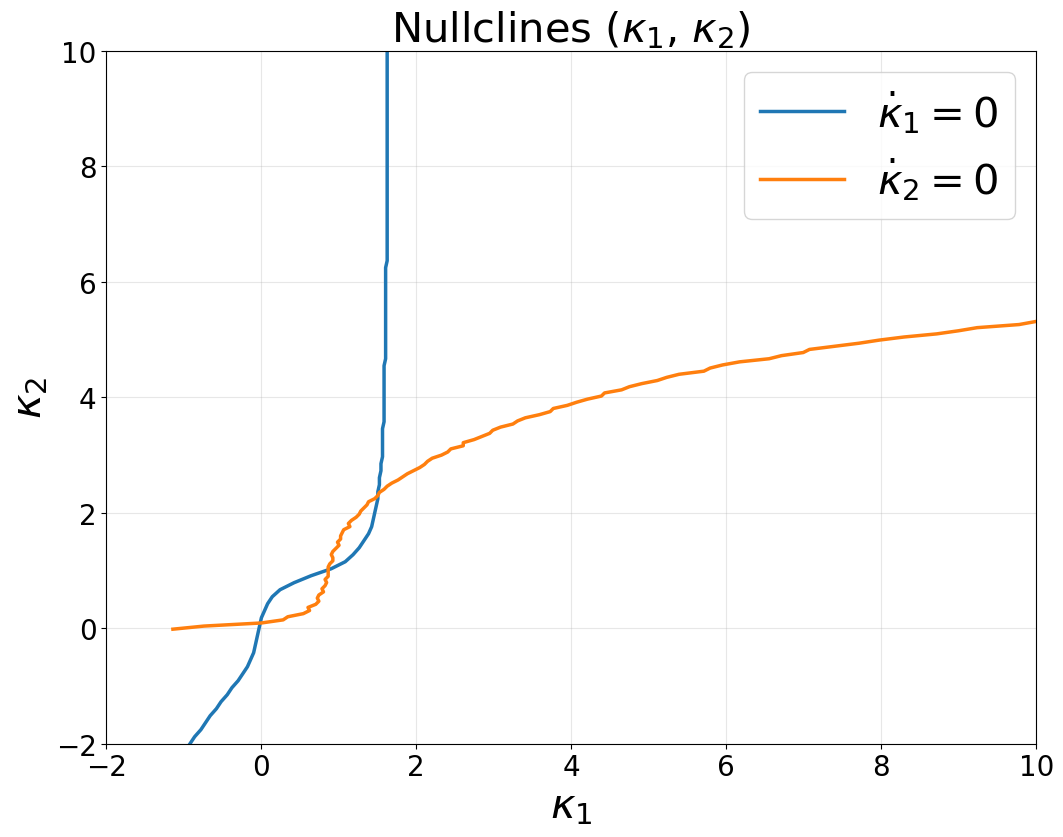

$\tau^c$ 0.12000000000000001


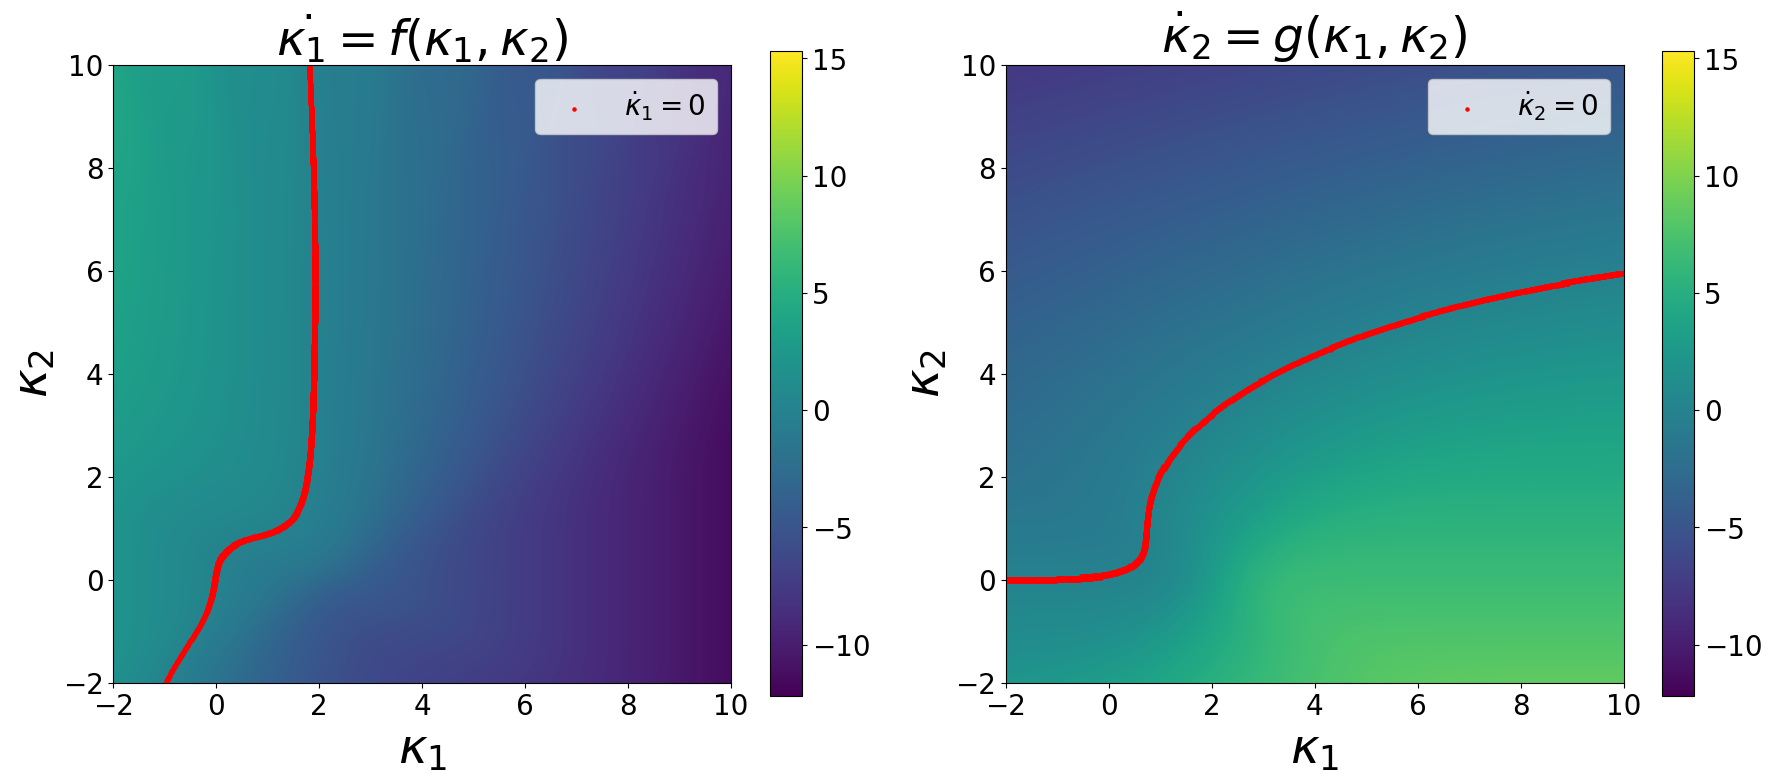

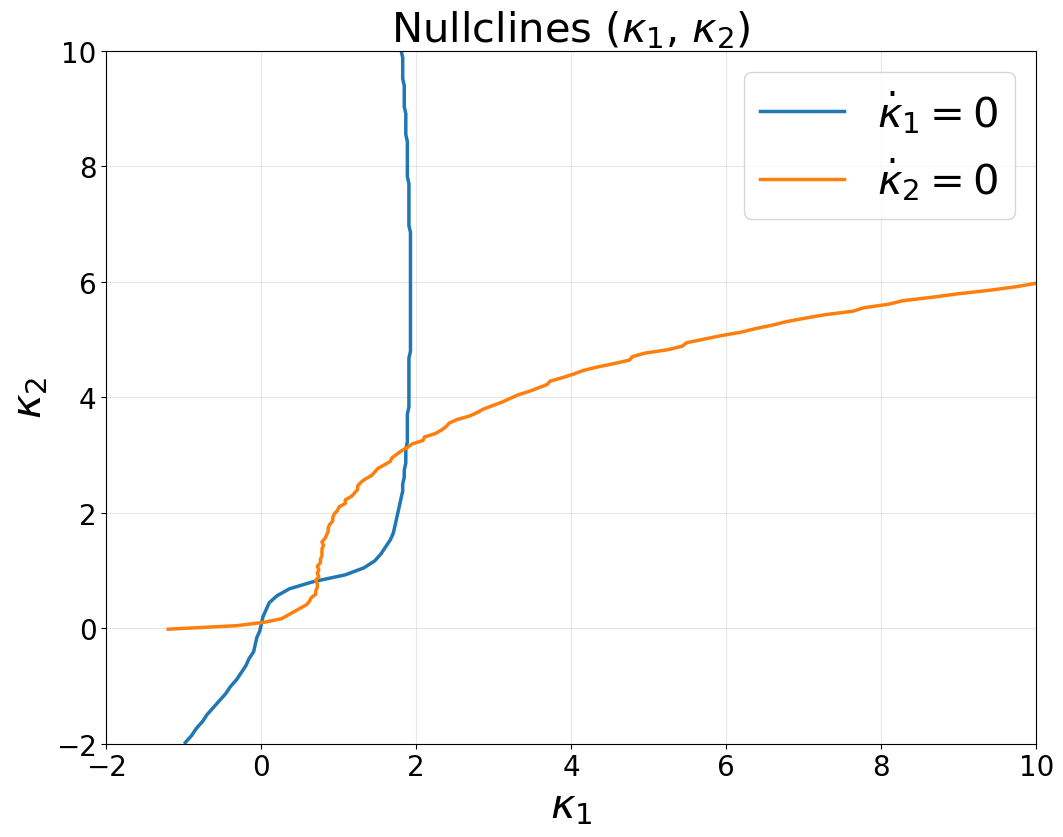

$\tau^c$ 0.15000000000000002


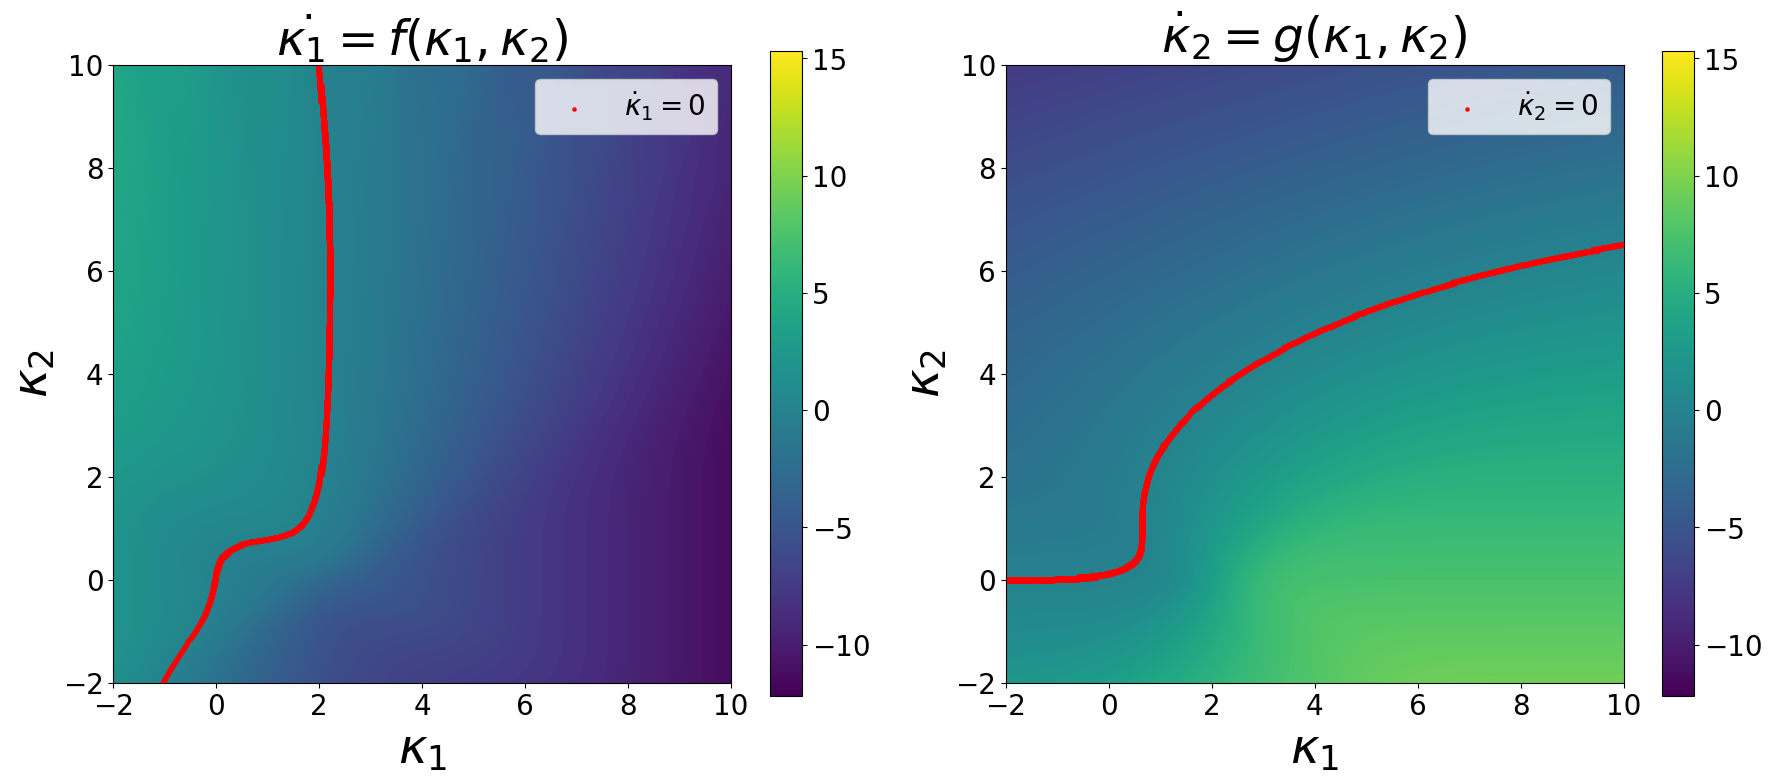

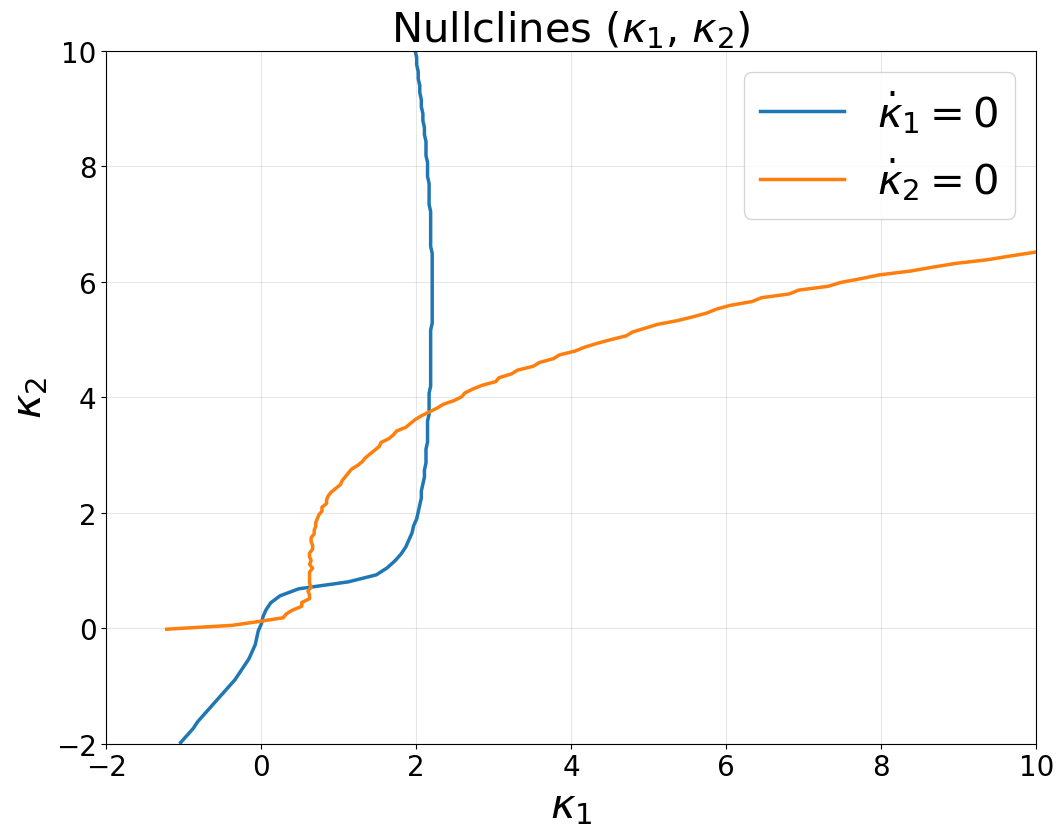

$\tau^c$ 0.18000000000000002


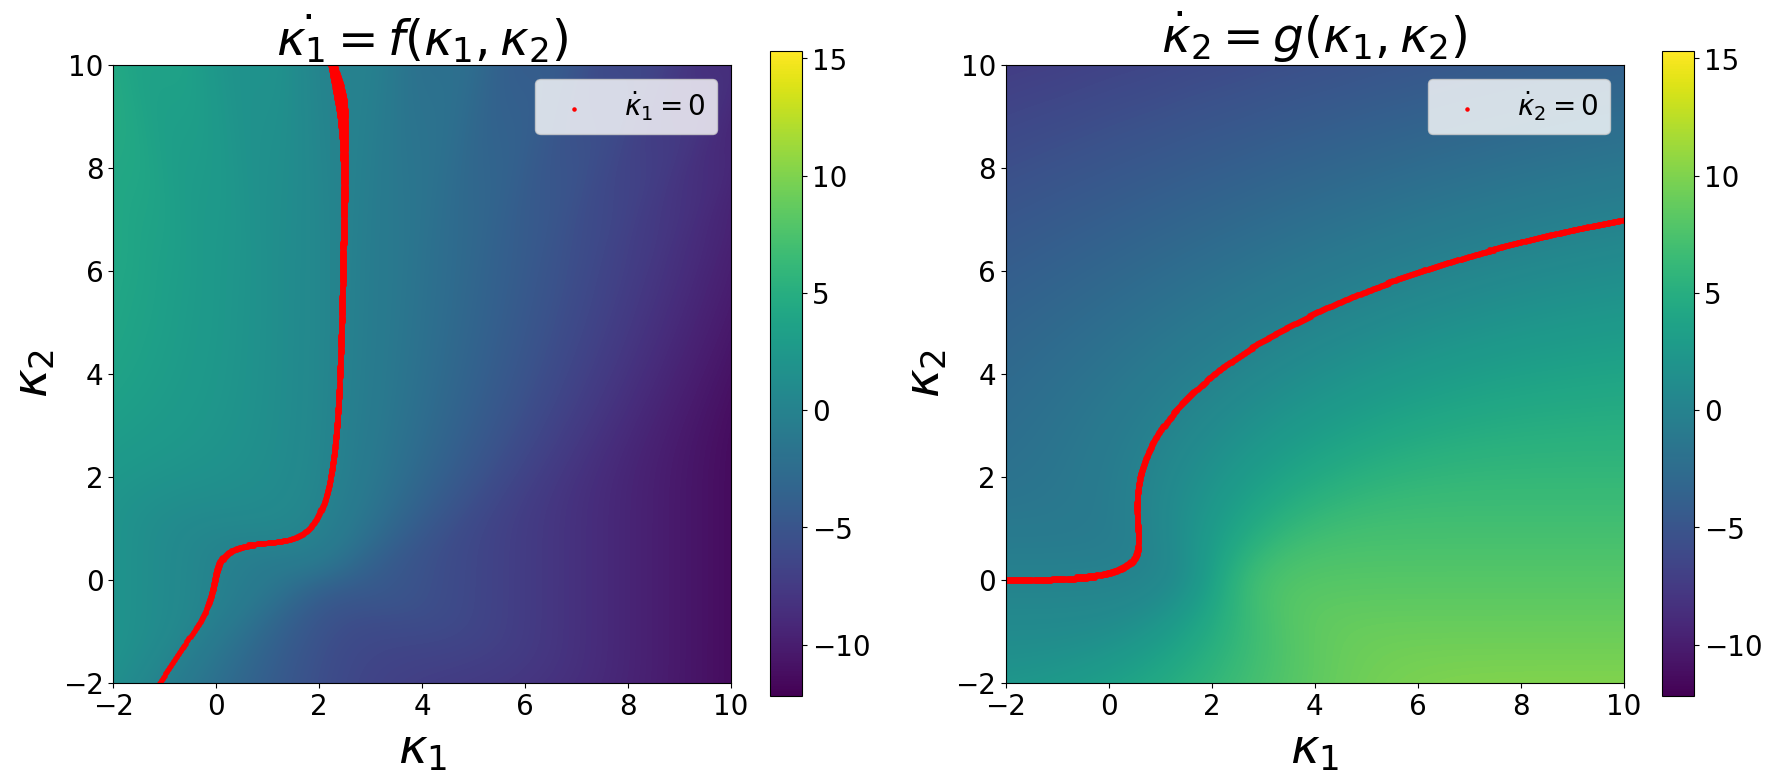

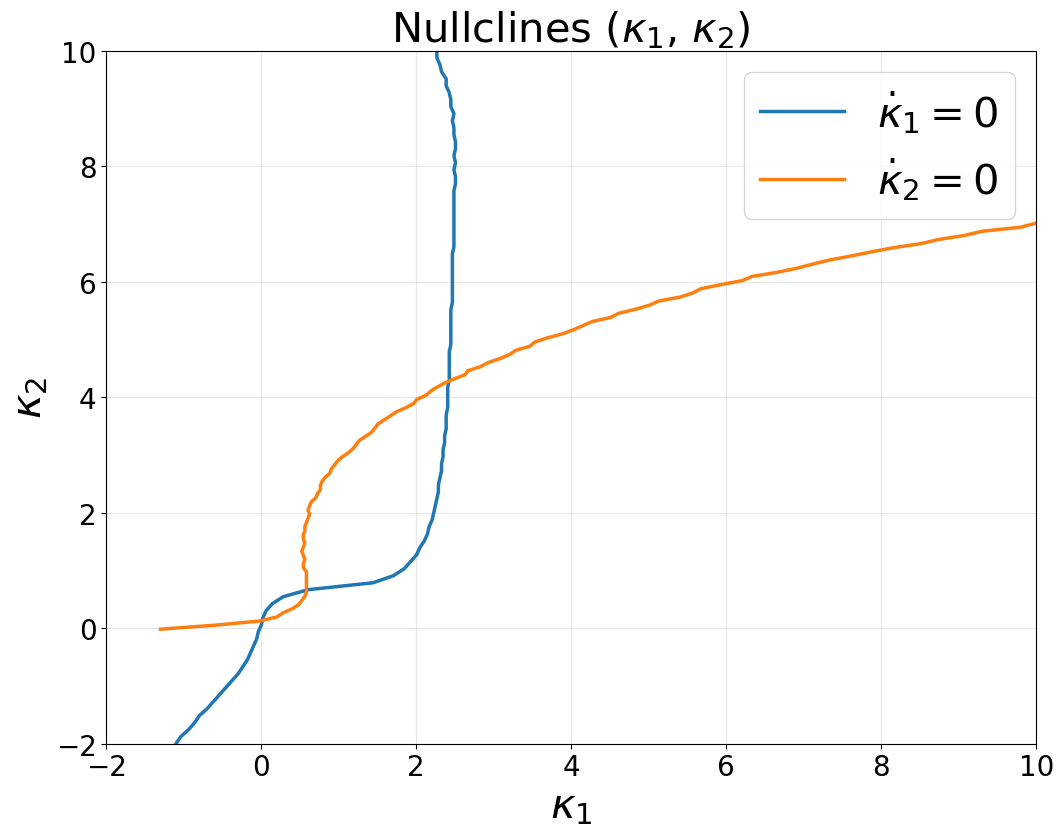

$\tau^c$ 0.21000000000000002


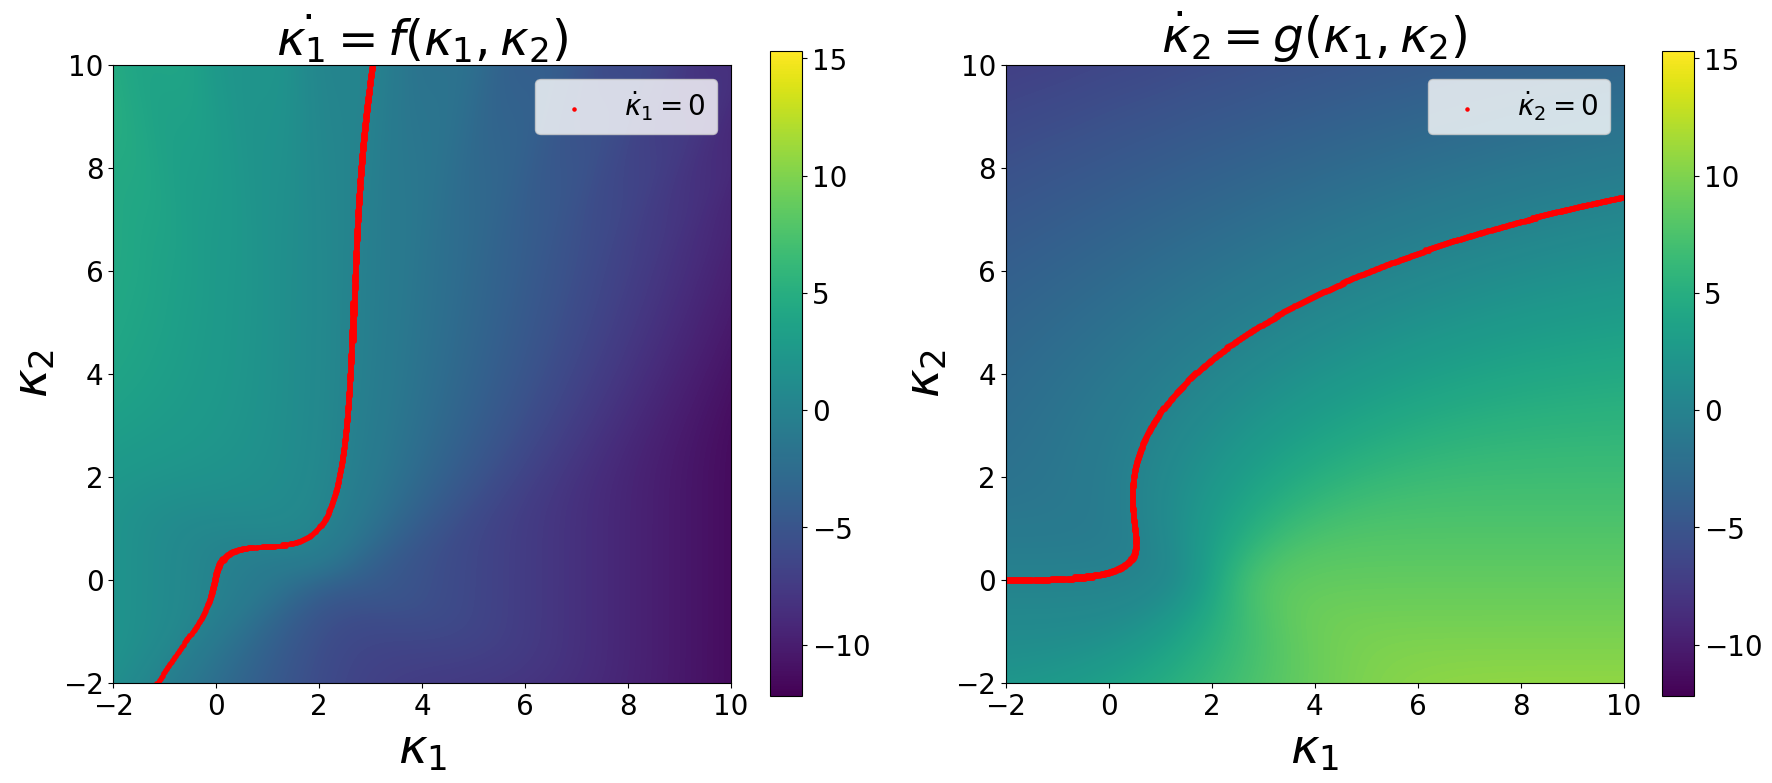

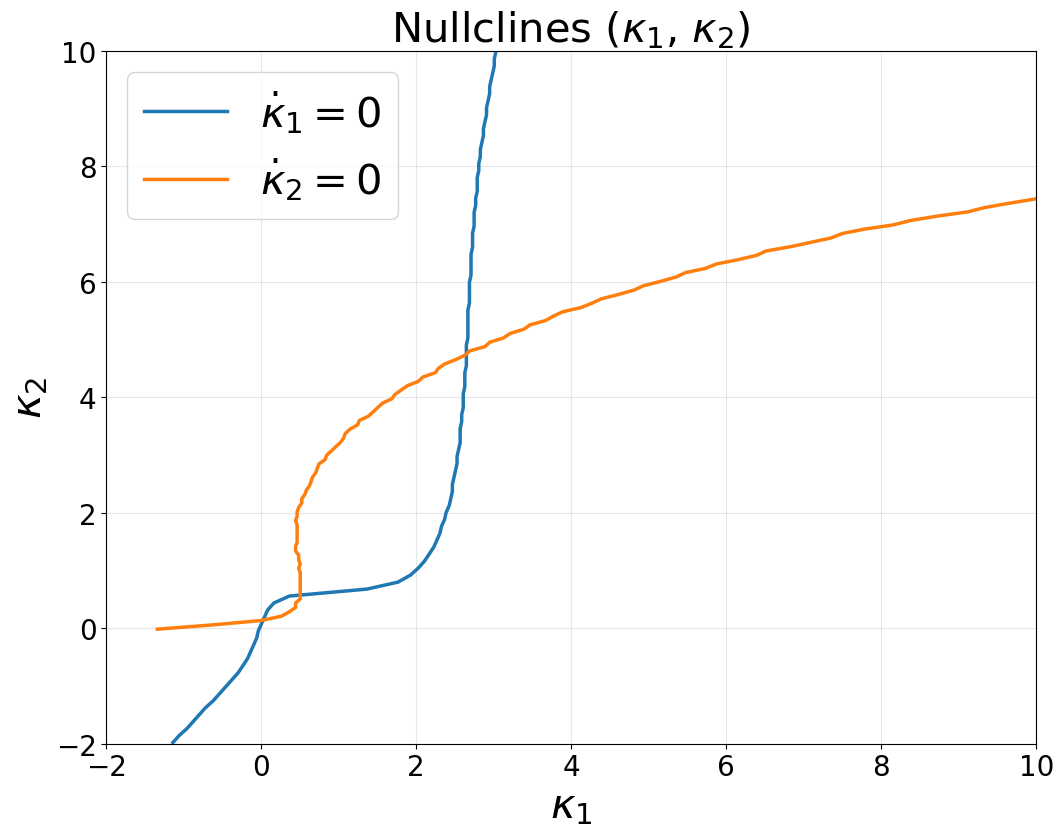

$\tau^c$ 0.24000000000000002


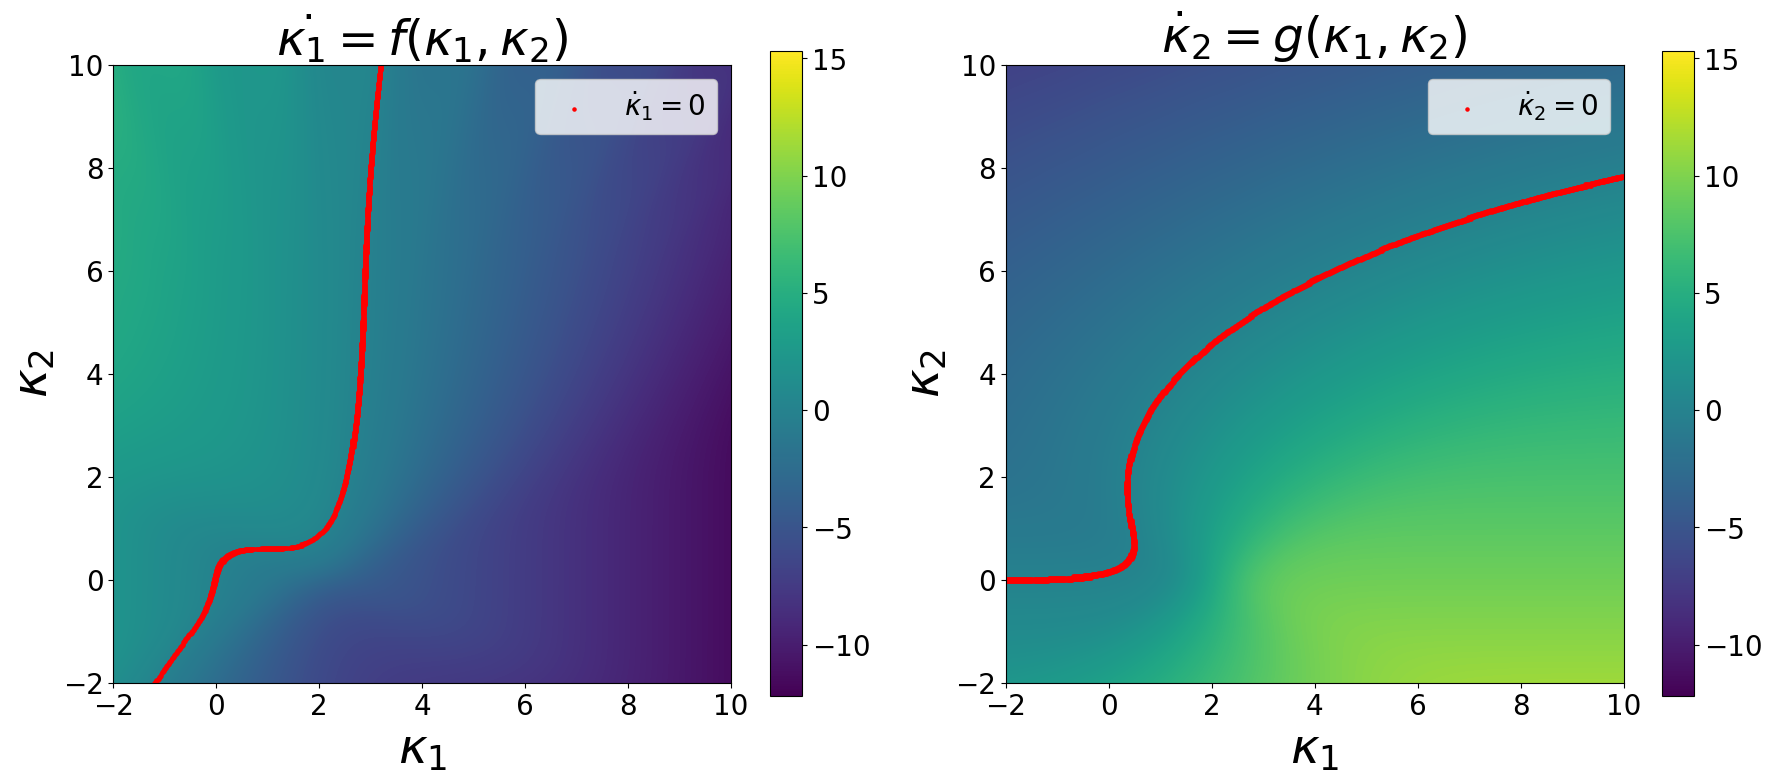

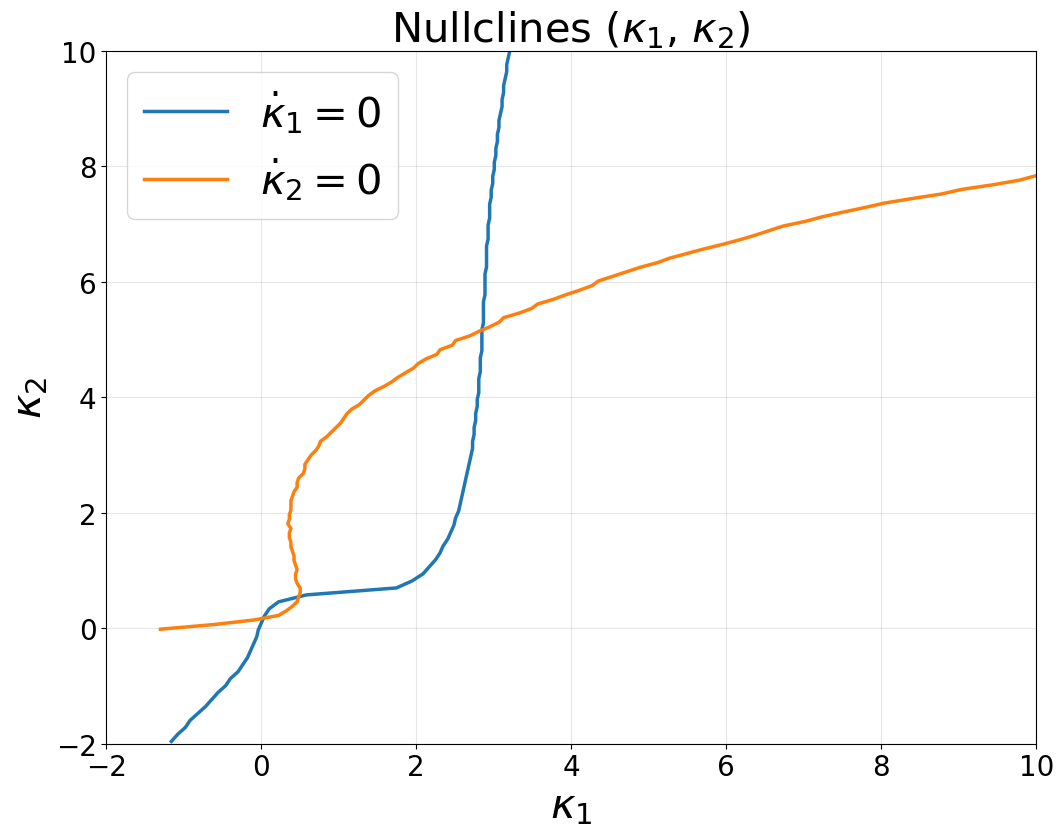

$\tau^c$ 0.27


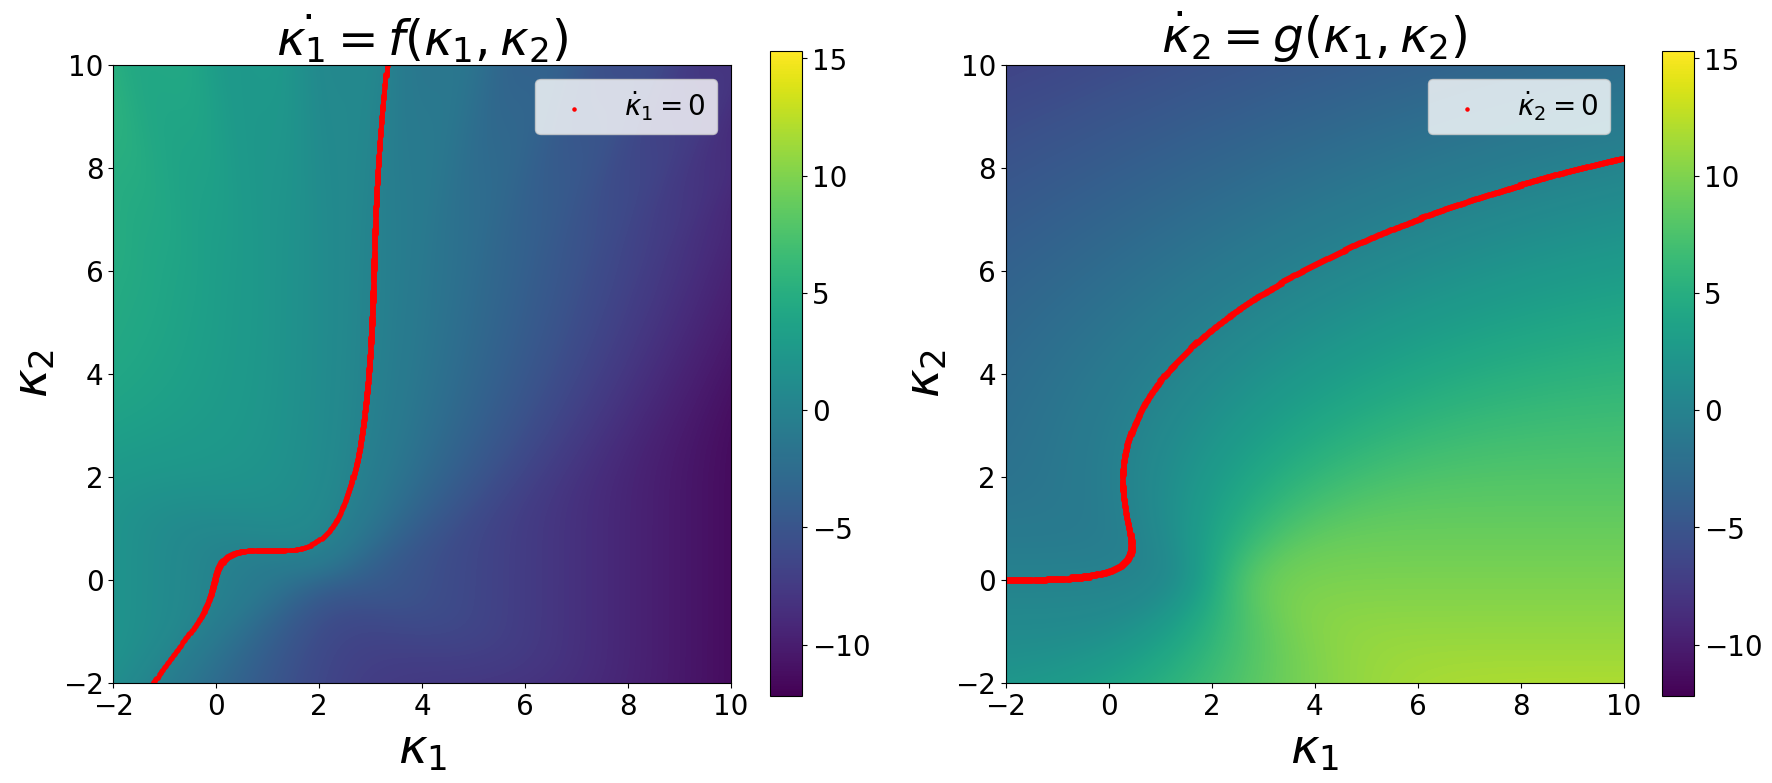

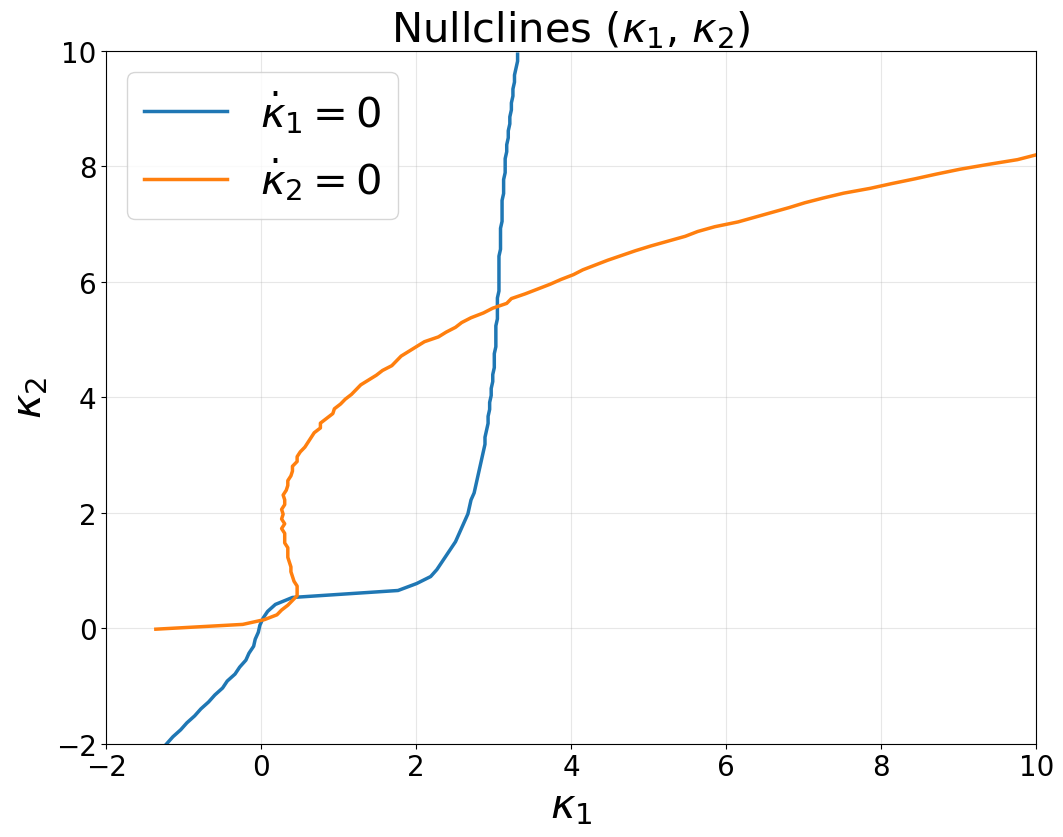

$\tau^c$ 0.30000000000000004


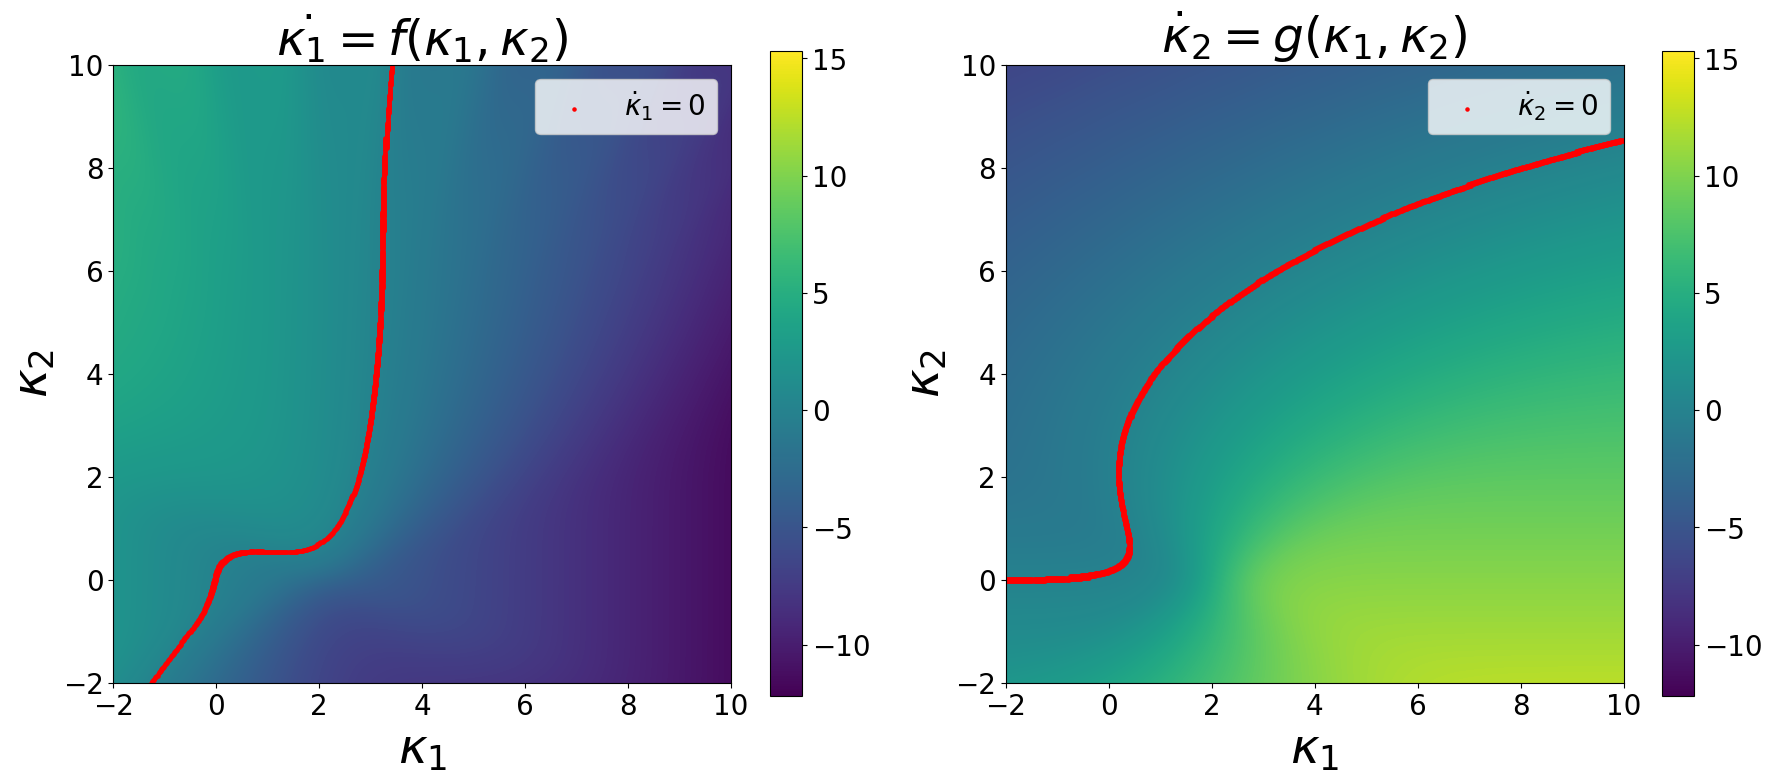

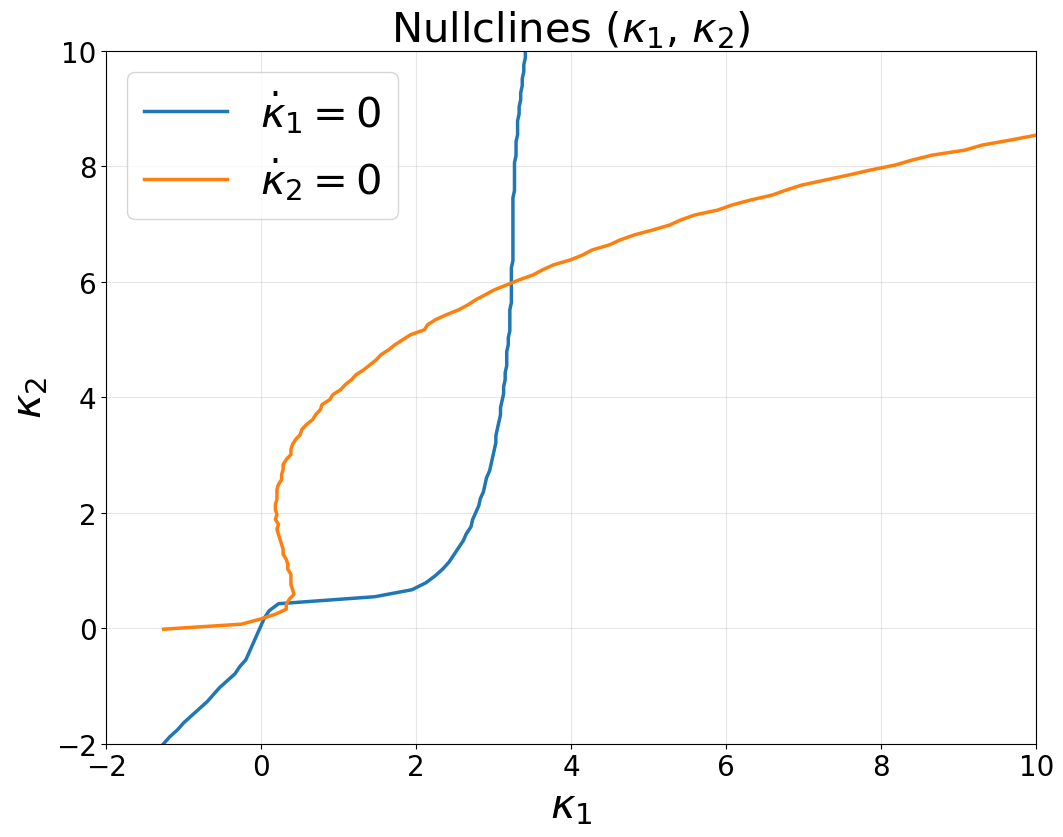

$\tau^c$ 0.33


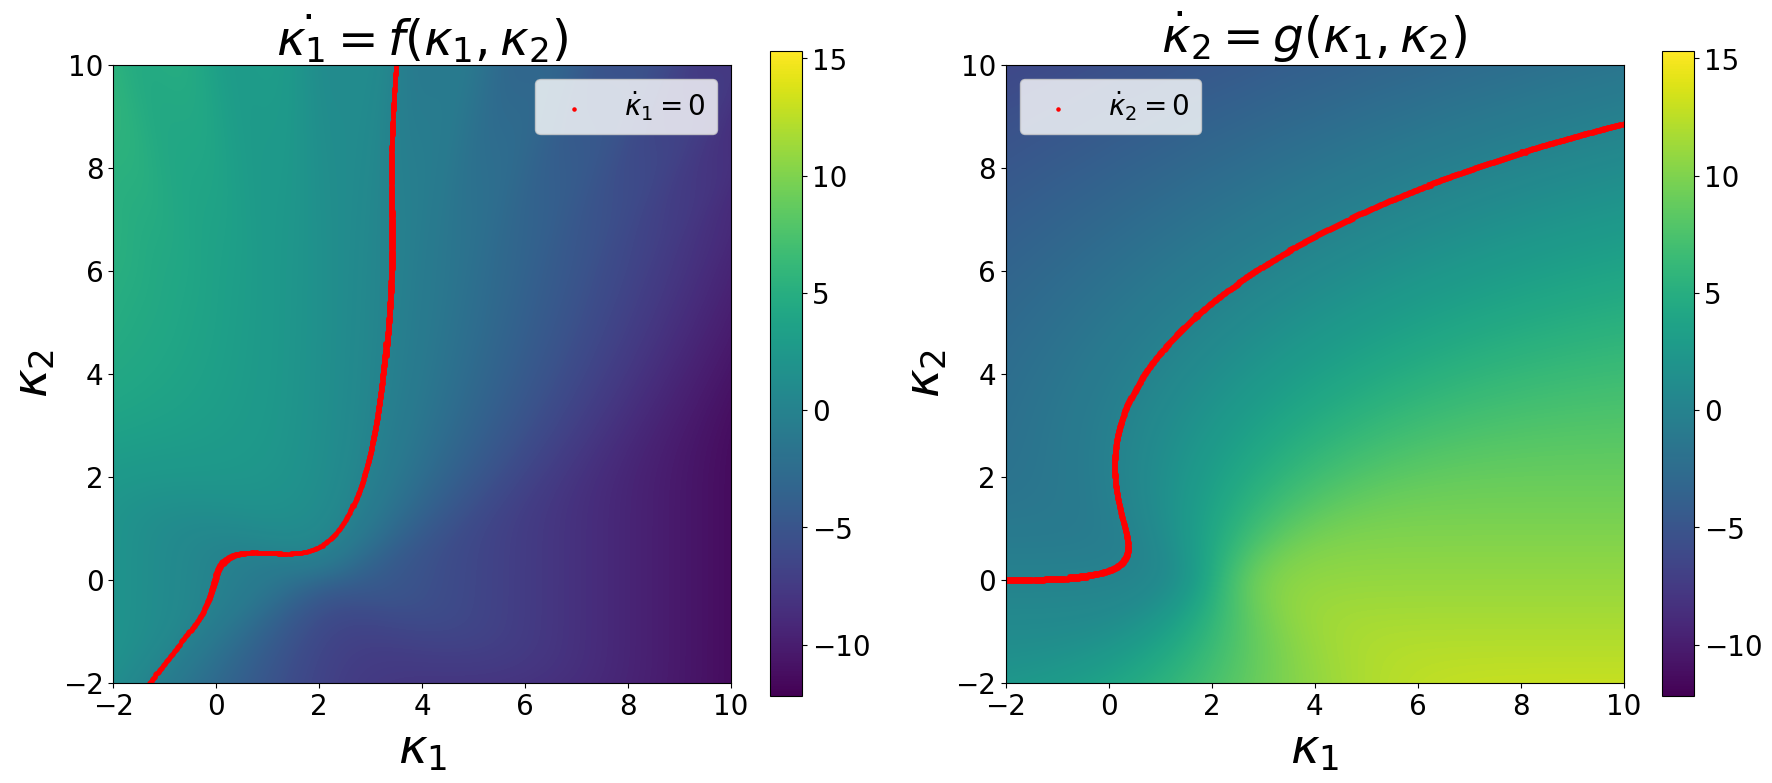

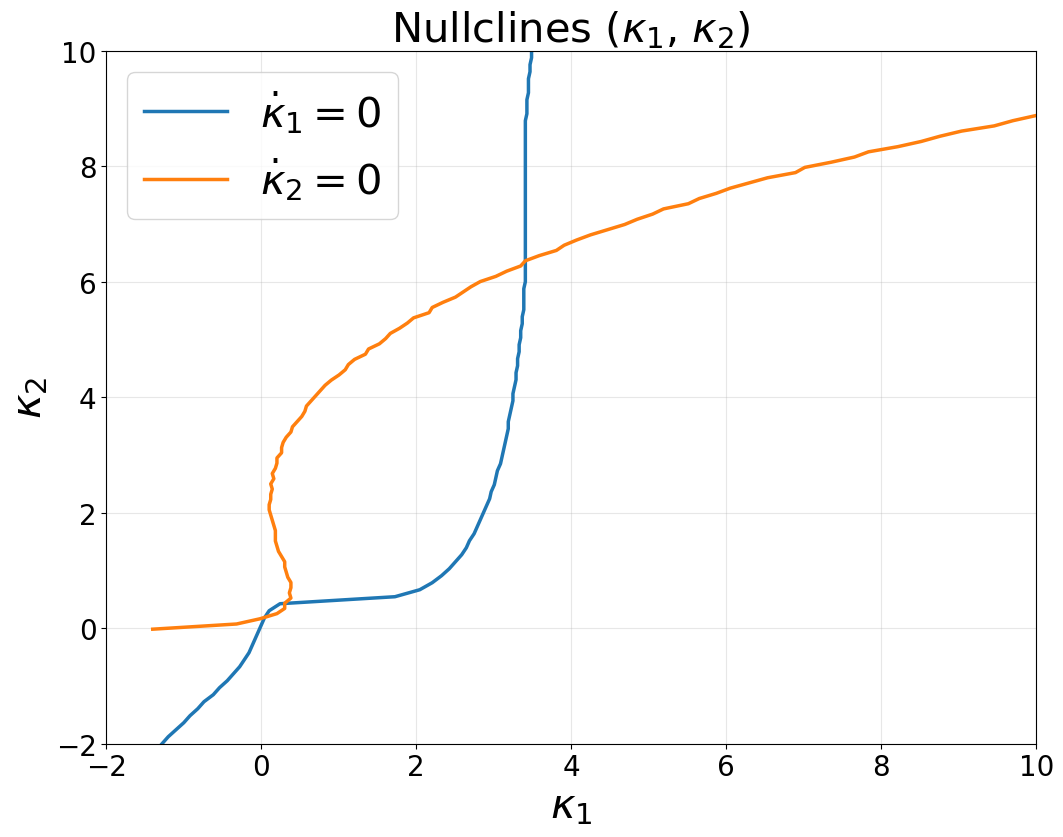

In [43]:
for tauc in tauc_list:
    print('$\\tau^c$', tauc)
    
    # 计算\dot{\kappa_1}
    def kappa1_dot(kappa1, kappa2):
        phi_val = Phi(kappa1, kappa2**2, bias, thres)
        phi_prime_val = derPhi(kappa1, kappa2**2, thres)
        return -kappa1 + (N_E - g * N_I) * j0 * phi_val + sigma * np.sqrt(N * tauc) * phi_prime_val * kappa2

    # 计算\dot{\kappa_2}
    def kappa2_dot(kappa1, kappa2):
        phi_val = Phi(kappa1, kappa2**2, bias, thres)
        return -kappa2 + sigma * np.sqrt(N * tauc) * phi_val
    
    # 生成网格
    kappa1_range = np.linspace(-2, 10, 600)
    kappa2_range = np.linspace(-2, 10, 600)
    kappa1_grid, kappa2_grid = np.meshgrid(kappa1_range, kappa2_range)

    # 计算\dot{\kappa_1}和\dot{\kappa_2}的网格值
    kappa1_dot_grid = np.zeros_like(kappa1_grid)
    kappa2_dot_grid = np.zeros_like(kappa2_grid)
    for i in range(len(kappa1_range)):
        for j in range(len(kappa2_range)):
            kappa1_dot_grid[j, i] = kappa1_dot(kappa1_grid[j, i], kappa2_grid[j, i])
            kappa2_dot_grid[j, i] = kappa2_dot(kappa1_grid[j, i], kappa2_grid[j, i])
            
    # 绘制\dot{\kappa_1}的heatmap
    plt.figure(figsize=(18, 7.5))
    plt.subplot(1, 2, 1)
    plt.imshow(kappa1_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis', vmin=-12.2, vmax=15.3)
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20) 
    #cbar.set_label(label='$\\dot{\\kappa}_1$', fontsize=30)  # 设置标签字体大小

    plt.xlabel('$\\kappa_1$', fontsize=35)
    plt.ylabel('$\\kappa_2$', fontsize=35)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('$\\dot{\\kappa_1}=f(\\kappa_1, \\kappa_2)$', fontsize=35)

    # 标记\dot{\kappa_1}=0的格点
    kappa1_zero = np.where(np.abs(kappa1_dot_grid) < 0.03)
    plt.scatter(kappa1_grid[kappa1_zero], kappa2_grid[kappa1_zero], color='red', s=5, label='$\\dot{\kappa}_1=0$')
    plt.legend(fontsize=20)

    # 绘制\dot{\kappa_2}的heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(kappa2_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis', vmin=-12.2, vmax=15.3)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20) 
    #cbar.set_label(label='$\\dot{\\kappa}_2$', fontsize=30)
    plt.xlabel('$\\kappa_1$', fontsize=35)
    plt.ylabel('$\\kappa_2$', fontsize=35)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('$\\dot{\\kappa}_2=g(\\kappa_1, \\kappa_2)$', fontsize=35)

    # 标记\dot{\kappa_2}=0的格点
    kappa2_zero = np.where(np.abs(kappa2_dot_grid) < 0.03)
    plt.scatter(kappa1_grid[kappa2_zero], kappa2_grid[kappa2_zero], color='red', s=5, label='$\\dot{\\kappa}_2=0$')
    plt.legend(fontsize=20)

    plt.tight_layout()
    plt.savefig(f'./nullcline_results_250915/kappa_dot_heatmaps_g{g}_j{j0}_tauc{tauc}.png')
    plt.show()


    # 准备数据用于拟合曲线（以-κ2为自变量x，κ1为因变量y进行插值）
    kappa1_vals = kappa1_grid.flatten()
    kappa2_vals = kappa2_grid.flatten()
    x_vals = -kappa2_vals  # 自变量x = -κ2
    y_vals = kappa1_vals   # 因变量y = κ1

    kappa1_dot_vals = kappa1_dot_grid.flatten()
    kappa2_dot_vals = kappa2_dot_grid.flatten()

    # 筛选\dot{\kappa_1}=0附近的数据点
    kappa1_zero_points = np.column_stack((
        x_vals[np.abs(kappa1_dot_vals) < 0.01],  # x = -κ2
        y_vals[np.abs(kappa1_dot_vals) < 0.01]   # y = κ1
    ))

    # 筛选\dot{\kappa_2}=0附近的数据点
    kappa2_zero_points = np.column_stack((
        x_vals[np.abs(kappa2_dot_vals) < 0.03],  # x = -κ2
        y_vals[np.abs(kappa2_dot_vals) < 0.03]   # y = κ1
    ))

    # 对\dot{\kappa_1}=0的数据点进行排序并拟合曲线
    if len(kappa1_zero_points) > 0:
        kappa1_zero_points = kappa1_zero_points[np.argsort(kappa1_zero_points[:, 0])]
        kappa1_zero_curve_x_interp = np.linspace(
            kappa1_zero_points[:, 0].min(), 
            kappa1_zero_points[:, 0].max(), 
            100
        )
        # 插值得到κ1值
        kappa1_zero_curve_y_interp = griddata(
            kappa1_zero_points[:, 0].reshape(-1, 1), 
            kappa1_zero_points[:, 1], 
            kappa1_zero_curve_x_interp, 
            method='nearest'
        )
        # 转换回(κ1, κ2)坐标用于绘图
        kappa1_nullcline_k1 = kappa1_zero_curve_y_interp  # κ1作为x轴
        kappa1_nullcline_k2 = -kappa1_zero_curve_x_interp  # κ2作为y轴（-x）
    else:
        print("未找到足够的κ1零倾线点")
        kappa1_nullcline_k1, kappa1_nullcline_k2 = [], []

    # 对\dot{\kappa_2}=0的数据点进行排序并拟合曲线
    if len(kappa2_zero_points) > 0:
        kappa2_zero_points = kappa2_zero_points[np.argsort(kappa2_zero_points[:, 0])]
        kappa2_zero_curve_x_interp = np.linspace(
            kappa2_zero_points[:, 0].min(), 
            kappa2_zero_points[:, 0].max(), 
            100
        )
        # 插值得到κ1值
        kappa2_zero_curve_y_interp = griddata(
            kappa2_zero_points[:, 0].reshape(-1, 1), 
            kappa2_zero_points[:, 1], 
            kappa2_zero_curve_x_interp, 
            method='nearest'
        )
        # 转换回(κ1, κ2)坐标用于绘图
        kappa2_nullcline_k1 = kappa2_zero_curve_y_interp  # κ1作为x轴
        kappa2_nullcline_k2 = -kappa2_zero_curve_x_interp  # κ2作为y轴（-x）
    else:
        print("未找到足够的κ2零倾线点")
        kappa2_nullcline_k1, kappa2_nullcline_k2 = [], []

    # 绘制拟合后的零倾线（以κ1为x轴，κ2为y轴）
    plt.figure(figsize=(12, 9))
    plt.plot(kappa1_nullcline_k1, kappa1_nullcline_k2, label='$\\dot{\\kappa}_1=0$' ,lw=2.5)
    plt.plot(kappa2_nullcline_k1, kappa2_nullcline_k2, label='$\\dot{\\kappa}_2=0$', lw=2.5)
    plt.xlabel('$\\kappa_1$', fontsize=30)  # x轴为κ1
    plt.ylabel('$\\kappa_2$', fontsize=30)  # y轴为κ2
    plt.title('Nullclines ($\\kappa_1$, $\\kappa_2$)', fontsize=30)
    plt.xlim(-2, 10)
    plt.ylim(-2, 10)
    plt.legend(fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True, alpha=0.3)
    plt.savefig(f'./nullcline_results_250915/nullcline_g{g}_j{j0}_tauc{tauc}.png')
    plt.show()

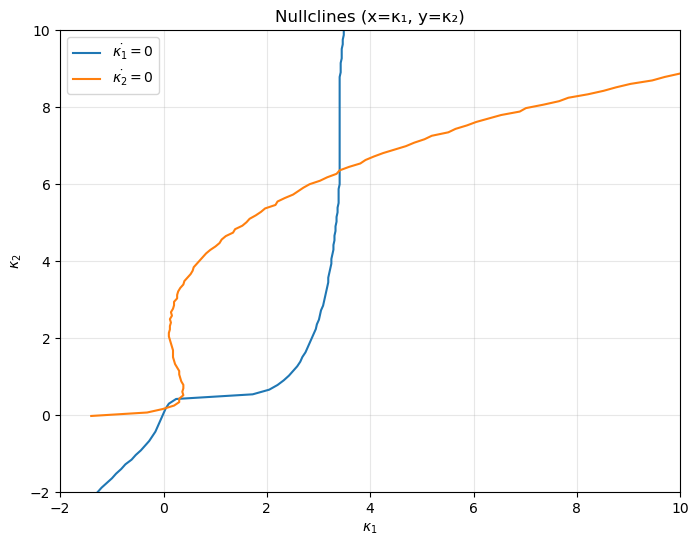

In [44]:
# 准备数据用于拟合曲线（以-κ2为自变量x，κ1为因变量y进行插值）
kappa1_vals = kappa1_grid.flatten()
kappa2_vals = kappa2_grid.flatten()
x_vals = -kappa2_vals  # 自变量x = -κ2
y_vals = kappa1_vals   # 因变量y = κ1

kappa1_dot_vals = kappa1_dot_grid.flatten()
kappa2_dot_vals = kappa2_dot_grid.flatten()

# 筛选\dot{\kappa_1}=0附近的数据点
kappa1_zero_points = np.column_stack((
    x_vals[np.abs(kappa1_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa1_dot_vals) < 0.01]   # y = κ1
))

# 筛选\dot{\kappa_2}=0附近的数据点
kappa2_zero_points = np.column_stack((
    x_vals[np.abs(kappa2_dot_vals) < 0.03],  # x = -κ2
    y_vals[np.abs(kappa2_dot_vals) < 0.03]   # y = κ1
))

# 对\dot{\kappa_1}=0的数据点进行排序并拟合曲线
if len(kappa1_zero_points) > 0:
    kappa1_zero_points = kappa1_zero_points[np.argsort(kappa1_zero_points[:, 0])]
    kappa1_zero_curve_x_interp = np.linspace(
        kappa1_zero_points[:, 0].min(), 
        kappa1_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa1_zero_curve_y_interp = griddata(
        kappa1_zero_points[:, 0].reshape(-1, 1), 
        kappa1_zero_points[:, 1], 
        kappa1_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa1_nullcline_k1 = kappa1_zero_curve_y_interp  # κ1作为x轴
    kappa1_nullcline_k2 = -kappa1_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ1零倾线点")
    kappa1_nullcline_k1, kappa1_nullcline_k2 = [], []

# 对\dot{\kappa_2}=0的数据点进行排序并拟合曲线
if len(kappa2_zero_points) > 0:
    kappa2_zero_points = kappa2_zero_points[np.argsort(kappa2_zero_points[:, 0])]
    kappa2_zero_curve_x_interp = np.linspace(
        kappa2_zero_points[:, 0].min(), 
        kappa2_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa2_zero_curve_y_interp = griddata(
        kappa2_zero_points[:, 0].reshape(-1, 1), 
        kappa2_zero_points[:, 1], 
        kappa2_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa2_nullcline_k1 = kappa2_zero_curve_y_interp  # κ1作为x轴
    kappa2_nullcline_k2 = -kappa2_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ2零倾线点")
    kappa2_nullcline_k1, kappa2_nullcline_k2 = [], []

# 绘制拟合后的零倾线（以κ1为x轴，κ2为y轴）
plt.figure(figsize=(8, 6))
plt.plot(kappa1_nullcline_k1, kappa1_nullcline_k2, label=r'$\dot{\kappa_1}=0$')
plt.plot(kappa2_nullcline_k1, kappa2_nullcline_k2, label=r'$\dot{\kappa_2}=0$')
plt.xlabel(r'$\kappa_1$')  # x轴为κ1
plt.ylabel(r'$\kappa_2$')  # y轴为κ2
plt.title('Nullclines (x=κ₁, y=κ₂)')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'./nullcline_results_250915/nullcline_g{g}_j{j0}_tauc{tauc}.png')
plt.show()

In [45]:

# 定义参数
sigma = 0.45
N = 800
tauc = 0.050
g = 3.5
j0 = 0.003
N_E = 600
N_I = 200
thres = 2.1
bias = 1.0


In [46]:
# 生成网格
kappa1_range = np.linspace(-2, 10, 400)
kappa2_range = np.linspace(-2, 10, 400)
kappa1_grid, kappa2_grid = np.meshgrid(kappa1_range, kappa2_range)

# 计算\dot{\kappa_1}和\dot{\kappa_2}的网格值
kappa1_dot_grid = np.zeros_like(kappa1_grid)
kappa2_dot_grid = np.zeros_like(kappa2_grid)
for i in range(len(kappa1_range)):
    for j in range(len(kappa2_range)):
        kappa1_dot_grid[j, i] = kappa1_dot(kappa1_grid[j, i], kappa2_grid[j, i])
        kappa2_dot_grid[j, i] = kappa2_dot(kappa1_grid[j, i], kappa2_grid[j, i])

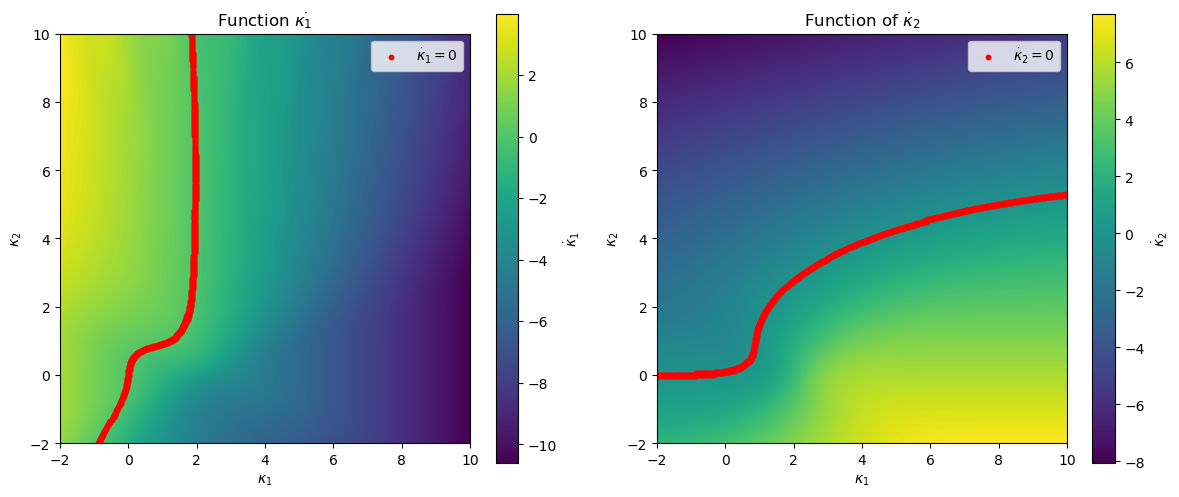

In [47]:
# 绘制\dot{\kappa_1}的heatmap
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(kappa1_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis')
plt.colorbar(label='$\\dot{\\kappa}_1$')
plt.xlabel('$\\kappa_1$')
plt.ylabel('$\\kappa_2$')
plt.title('Function $\dot{\kappa_1}$')

# 标记\dot{\kappa_1}=0的格点
kappa1_zero = np.where(np.abs(kappa1_dot_grid) < 0.03)
plt.scatter(kappa1_grid[kappa1_zero], kappa2_grid[kappa1_zero], color='red', s=10, label='$\\dot{\kappa}_1=0$')
plt.legend()

# 绘制\dot{\kappa_2}的heatmap
plt.subplot(1, 2, 2)
plt.imshow(kappa2_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis')
plt.colorbar(label='$\\dot{\\kappa}_2$')
plt.xlabel('$\\kappa_1$')
plt.ylabel('$\\kappa_2$')
plt.title('Function of $\\dot{\\kappa}_2$')

# 标记\dot{\kappa_2}=0的格点
kappa2_zero = np.where(np.abs(kappa2_dot_grid) < 0.03)
plt.scatter(kappa1_grid[kappa2_zero], kappa2_grid[kappa2_zero], color='red', s=10, label='$\\dot{\\kappa}_2=0$')
plt.legend()

plt.tight_layout()
plt.savefig(f'./nullcline_results_250915/kappa_dot_heatmaps_g{g}_j{j0}_tauc{tauc}.png')
plt.show()

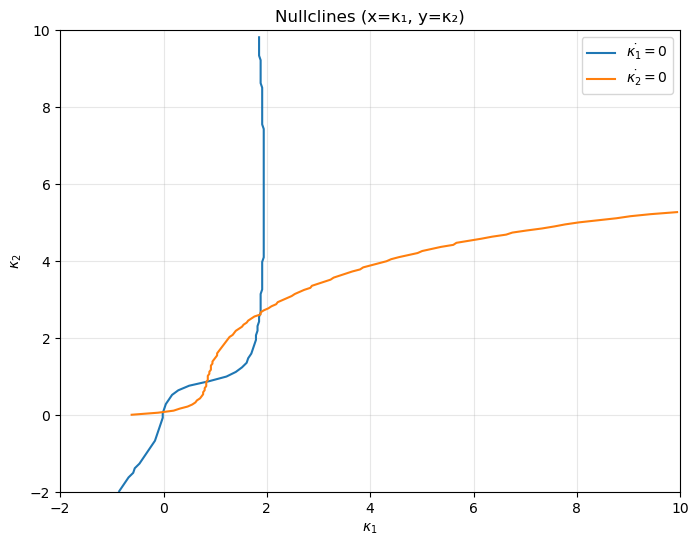

In [48]:
# 准备数据用于拟合曲线（以-κ2为自变量x，κ1为因变量y进行插值）
kappa1_vals = kappa1_grid.flatten()
kappa2_vals = kappa2_grid.flatten()
x_vals = -kappa2_vals  # 自变量x = -κ2
y_vals = kappa1_vals   # 因变量y = κ1

kappa1_dot_vals = kappa1_dot_grid.flatten()
kappa2_dot_vals = kappa2_dot_grid.flatten()

# 筛选\dot{\kappa_1}=0附近的数据点
kappa1_zero_points = np.column_stack((
    x_vals[np.abs(kappa1_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa1_dot_vals) < 0.01]   # y = κ1
))

# 筛选\dot{\kappa_2}=0附近的数据点
kappa2_zero_points = np.column_stack((
    x_vals[np.abs(kappa2_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa2_dot_vals) < 0.01]   # y = κ1
))

# 对\dot{\kappa_1}=0的数据点进行排序并拟合曲线
if len(kappa1_zero_points) > 0:
    kappa1_zero_points = kappa1_zero_points[np.argsort(kappa1_zero_points[:, 0])]
    kappa1_zero_curve_x_interp = np.linspace(
        kappa1_zero_points[:, 0].min(), 
        kappa1_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa1_zero_curve_y_interp = griddata(
        kappa1_zero_points[:, 0].reshape(-1, 1), 
        kappa1_zero_points[:, 1], 
        kappa1_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa1_nullcline_k1 = kappa1_zero_curve_y_interp  # κ1作为x轴
    kappa1_nullcline_k2 = -kappa1_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ1零倾线点")
    kappa1_nullcline_k1, kappa1_nullcline_k2 = [], []

# 对\dot{\kappa_2}=0的数据点进行排序并拟合曲线
if len(kappa2_zero_points) > 0:
    kappa2_zero_points = kappa2_zero_points[np.argsort(kappa2_zero_points[:, 0])]
    kappa2_zero_curve_x_interp = np.linspace(
        kappa2_zero_points[:, 0].min(), 
        kappa2_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa2_zero_curve_y_interp = griddata(
        kappa2_zero_points[:, 0].reshape(-1, 1), 
        kappa2_zero_points[:, 1], 
        kappa2_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa2_nullcline_k1 = kappa2_zero_curve_y_interp  # κ1作为x轴
    kappa2_nullcline_k2 = -kappa2_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ2零倾线点")
    kappa2_nullcline_k1, kappa2_nullcline_k2 = [], []

# 绘制拟合后的零倾线（以κ1为x轴，κ2为y轴）
plt.figure(figsize=(8, 6))
plt.plot(kappa1_nullcline_k1, kappa1_nullcline_k2, label=r'$\dot{\kappa_1}=0$')
plt.plot(kappa2_nullcline_k1, kappa2_nullcline_k2, label=r'$\dot{\kappa_2}=0$')
plt.xlabel(r'$\kappa_1$')  # x轴为κ1
plt.ylabel(r'$\kappa_2$')  # y轴为κ2
plt.title('Nullclines (x=κ₁, y=κ₂)')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'./nullcline_results_250915/nullcline_g{g}_j{j0}_tauc{tauc}.png')
plt.show()

In [49]:

# 定义参数
sigma = 0.45
N = 800
tauc = 0.100
g = 3.5
j0 = 0.003
N_E = 600
N_I = 200
thres = 2.1
bias = 1.0


In [50]:
# 生成网格
kappa1_range = np.linspace(-2, 10, 400)
kappa2_range = np.linspace(-2, 10, 400)
kappa1_grid, kappa2_grid = np.meshgrid(kappa1_range, kappa2_range)

# 计算\dot{\kappa_1}和\dot{\kappa_2}的网格值
kappa1_dot_grid = np.zeros_like(kappa1_grid)
kappa2_dot_grid = np.zeros_like(kappa2_grid)
for i in range(len(kappa1_range)):
    for j in range(len(kappa2_range)):
        kappa1_dot_grid[j, i] = kappa1_dot(kappa1_grid[j, i], kappa2_grid[j, i])
        kappa2_dot_grid[j, i] = kappa2_dot(kappa1_grid[j, i], kappa2_grid[j, i])

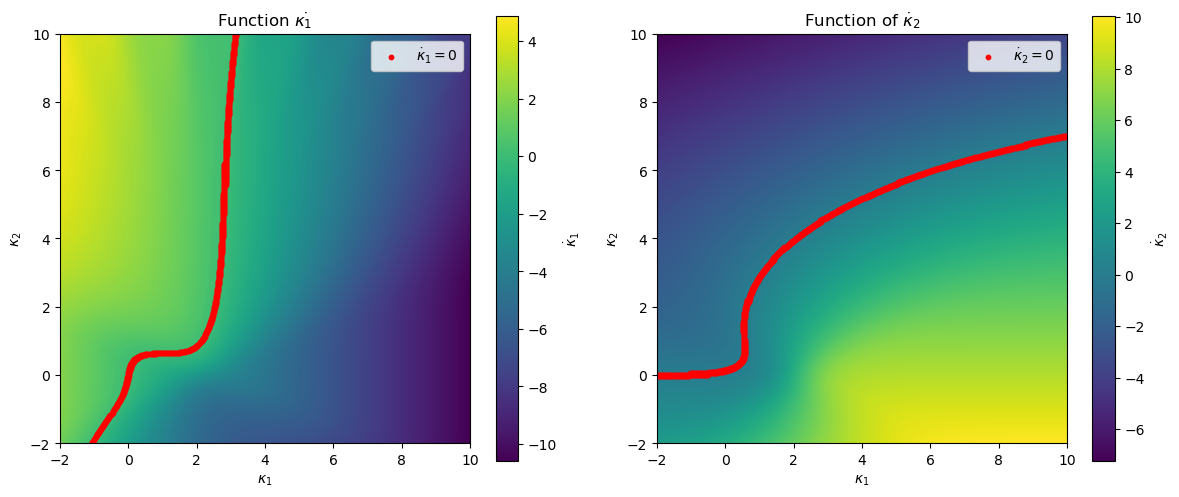

In [51]:
# 绘制\dot{\kappa_1}的heatmap
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(kappa1_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis')
plt.colorbar(label='$\\dot{\\kappa}_1$')
plt.xlabel('$\\kappa_1$')
plt.ylabel('$\\kappa_2$')
plt.title('Function $\dot{\kappa_1}$')

# 标记\dot{\kappa_1}=0的格点
kappa1_zero = np.where(np.abs(kappa1_dot_grid) < 0.03)
plt.scatter(kappa1_grid[kappa1_zero], kappa2_grid[kappa1_zero], color='red', s=10, label='$\\dot{\kappa}_1=0$')
plt.legend()

# 绘制\dot{\kappa_2}的heatmap
plt.subplot(1, 2, 2)
plt.imshow(kappa2_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis')
plt.colorbar(label='$\\dot{\\kappa}_2$')
plt.xlabel('$\\kappa_1$')
plt.ylabel('$\\kappa_2$')
plt.title('Function of $\\dot{\\kappa}_2$')

# 标记\dot{\kappa_2}=0的格点
kappa2_zero = np.where(np.abs(kappa2_dot_grid) < 0.03)
plt.scatter(kappa1_grid[kappa2_zero], kappa2_grid[kappa2_zero], color='red', s=10, label='$\\dot{\\kappa}_2=0$')
plt.legend()

plt.tight_layout()
plt.savefig(f'./nullcline_results_250915/kappa_dot_heatmaps_g{g}_j{j0}_tauc{tauc}.png')
plt.show()

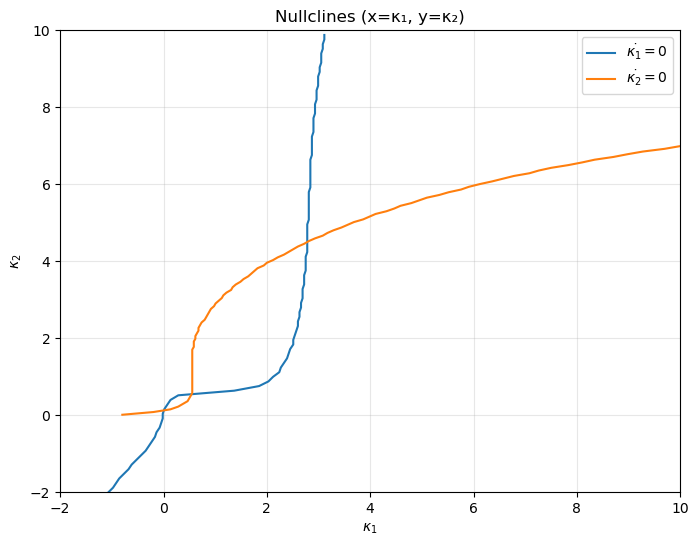

In [52]:
# 准备数据用于拟合曲线（以-κ2为自变量x，κ1为因变量y进行插值）
kappa1_vals = kappa1_grid.flatten()
kappa2_vals = kappa2_grid.flatten()
x_vals = -kappa2_vals  # 自变量x = -κ2
y_vals = kappa1_vals   # 因变量y = κ1

kappa1_dot_vals = kappa1_dot_grid.flatten()
kappa2_dot_vals = kappa2_dot_grid.flatten()

# 筛选\dot{\kappa_1}=0附近的数据点
kappa1_zero_points = np.column_stack((
    x_vals[np.abs(kappa1_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa1_dot_vals) < 0.01]   # y = κ1
))

# 筛选\dot{\kappa_2}=0附近的数据点
kappa2_zero_points = np.column_stack((
    x_vals[np.abs(kappa2_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa2_dot_vals) < 0.01]   # y = κ1
))

# 对\dot{\kappa_1}=0的数据点进行排序并拟合曲线
if len(kappa1_zero_points) > 0:
    kappa1_zero_points = kappa1_zero_points[np.argsort(kappa1_zero_points[:, 0])]
    kappa1_zero_curve_x_interp = np.linspace(
        kappa1_zero_points[:, 0].min(), 
        kappa1_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa1_zero_curve_y_interp = griddata(
        kappa1_zero_points[:, 0].reshape(-1, 1), 
        kappa1_zero_points[:, 1], 
        kappa1_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa1_nullcline_k1 = kappa1_zero_curve_y_interp  # κ1作为x轴
    kappa1_nullcline_k2 = -kappa1_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ1零倾线点")
    kappa1_nullcline_k1, kappa1_nullcline_k2 = [], []

# 对\dot{\kappa_2}=0的数据点进行排序并拟合曲线
if len(kappa2_zero_points) > 0:
    kappa2_zero_points = kappa2_zero_points[np.argsort(kappa2_zero_points[:, 0])]
    kappa2_zero_curve_x_interp = np.linspace(
        kappa2_zero_points[:, 0].min(), 
        kappa2_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa2_zero_curve_y_interp = griddata(
        kappa2_zero_points[:, 0].reshape(-1, 1), 
        kappa2_zero_points[:, 1], 
        kappa2_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa2_nullcline_k1 = kappa2_zero_curve_y_interp  # κ1作为x轴
    kappa2_nullcline_k2 = -kappa2_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ2零倾线点")
    kappa2_nullcline_k1, kappa2_nullcline_k2 = [], []

# 绘制拟合后的零倾线（以κ1为x轴，κ2为y轴）
plt.figure(figsize=(8, 6))
plt.plot(kappa1_nullcline_k1, kappa1_nullcline_k2, label=r'$\dot{\kappa_1}=0$')
plt.plot(kappa2_nullcline_k1, kappa2_nullcline_k2, label=r'$\dot{\kappa_2}=0$')
plt.xlabel(r'$\kappa_1$')  # x轴为κ1
plt.ylabel(r'$\kappa_2$')  # y轴为κ2
plt.title('Nullclines (x=κ₁, y=κ₂)')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'./nullcline_results_250915/nullcline_g{g}_j{j0}_tauc{tauc}.png')
plt.show()

In [53]:
# 定义参数
sigma = 0.45
N = 800
tauc = 0.150
g = 3.5
j0 = 0.003
N_E = 600
N_I = 200
thres = 2.1
bias = 1.0

In [54]:
# 生成网格
kappa1_range = np.linspace(-2, 10, 400)
kappa2_range = np.linspace(-2, 10, 400)
kappa1_grid, kappa2_grid = np.meshgrid(kappa1_range, kappa2_range)

# 计算\dot{\kappa_1}和\dot{\kappa_2}的网格值
kappa1_dot_grid = np.zeros_like(kappa1_grid)
kappa2_dot_grid = np.zeros_like(kappa2_grid)
for i in range(len(kappa1_range)):
    for j in range(len(kappa2_range)):
        kappa1_dot_grid[j, i] = kappa1_dot(kappa1_grid[j, i], kappa2_grid[j, i])
        kappa2_dot_grid[j, i] = kappa2_dot(kappa1_grid[j, i], kappa2_grid[j, i])

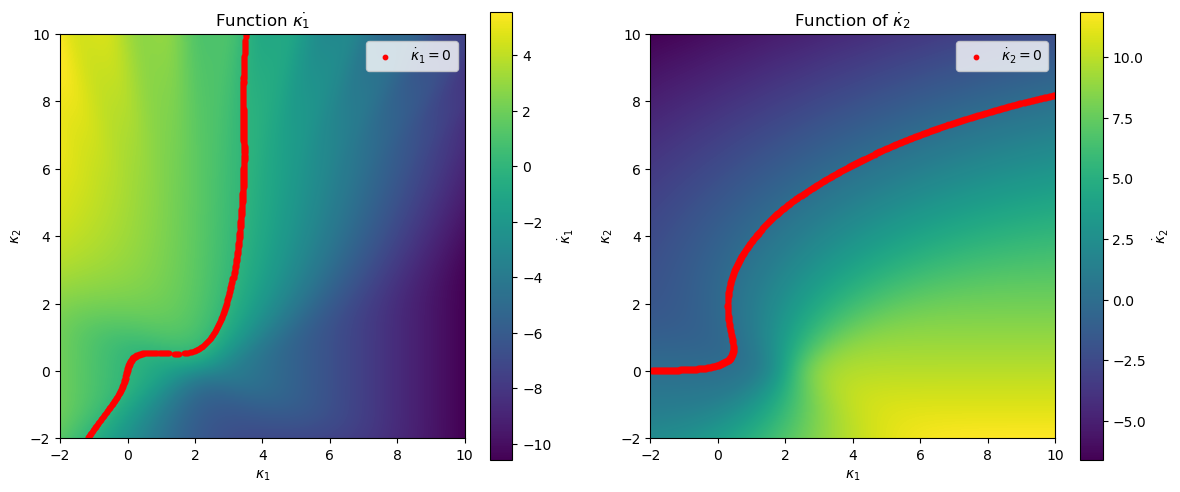

In [55]:
# 绘制\dot{\kappa_1}的heatmap
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(kappa1_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis')
plt.colorbar(label='$\\dot{\\kappa}_1$')
plt.xlabel('$\\kappa_1$')
plt.ylabel('$\\kappa_2$')
plt.title('Function $\dot{\kappa_1}$')

# 标记\dot{\kappa_1}=0的格点
kappa1_zero = np.where(np.abs(kappa1_dot_grid) < 0.03)
plt.scatter(kappa1_grid[kappa1_zero], kappa2_grid[kappa1_zero], color='red', s=10, label='$\\dot{\kappa}_1=0$')
plt.legend()

# 绘制\dot{\kappa_2}的heatmap
plt.subplot(1, 2, 2)
plt.imshow(kappa2_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis')
plt.colorbar(label='$\\dot{\\kappa}_2$')
plt.xlabel('$\\kappa_1$')
plt.ylabel('$\\kappa_2$')
plt.title('Function of $\\dot{\\kappa}_2$')

# 标记\dot{\kappa_2}=0的格点
kappa2_zero = np.where(np.abs(kappa2_dot_grid) < 0.03)
plt.scatter(kappa1_grid[kappa2_zero], kappa2_grid[kappa2_zero], color='red', s=10, label='$\\dot{\\kappa}_2=0$')
plt.legend()

plt.tight_layout()
plt.savefig(f'./nullcline_results_250915/kappa_dot_heatmaps_g{g}_j{j0}_tauc{tauc}.png')
plt.show()

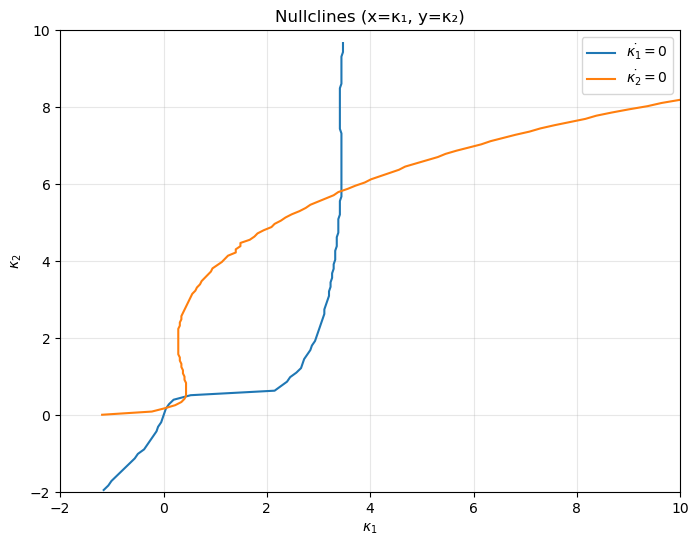

In [56]:
# 准备数据用于拟合曲线（以-κ2为自变量x，κ1为因变量y进行插值）
kappa1_vals = kappa1_grid.flatten()
kappa2_vals = kappa2_grid.flatten()
x_vals = -kappa2_vals  # 自变量x = -κ2
y_vals = kappa1_vals   # 因变量y = κ1

kappa1_dot_vals = kappa1_dot_grid.flatten()
kappa2_dot_vals = kappa2_dot_grid.flatten()

# 筛选\dot{\kappa_1}=0附近的数据点
kappa1_zero_points = np.column_stack((
    x_vals[np.abs(kappa1_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa1_dot_vals) < 0.01]   # y = κ1
))

# 筛选\dot{\kappa_2}=0附近的数据点
kappa2_zero_points = np.column_stack((
    x_vals[np.abs(kappa2_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa2_dot_vals) < 0.01]   # y = κ1
))

# 对\dot{\kappa_1}=0的数据点进行排序并拟合曲线
if len(kappa1_zero_points) > 0:
    kappa1_zero_points = kappa1_zero_points[np.argsort(kappa1_zero_points[:, 0])]
    kappa1_zero_curve_x_interp = np.linspace(
        kappa1_zero_points[:, 0].min(), 
        kappa1_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa1_zero_curve_y_interp = griddata(
        kappa1_zero_points[:, 0].reshape(-1, 1), 
        kappa1_zero_points[:, 1], 
        kappa1_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa1_nullcline_k1 = kappa1_zero_curve_y_interp  # κ1作为x轴
    kappa1_nullcline_k2 = -kappa1_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ1零倾线点")
    kappa1_nullcline_k1, kappa1_nullcline_k2 = [], []

# 对\dot{\kappa_2}=0的数据点进行排序并拟合曲线
if len(kappa2_zero_points) > 0:
    kappa2_zero_points = kappa2_zero_points[np.argsort(kappa2_zero_points[:, 0])]
    kappa2_zero_curve_x_interp = np.linspace(
        kappa2_zero_points[:, 0].min(), 
        kappa2_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa2_zero_curve_y_interp = griddata(
        kappa2_zero_points[:, 0].reshape(-1, 1), 
        kappa2_zero_points[:, 1], 
        kappa2_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa2_nullcline_k1 = kappa2_zero_curve_y_interp  # κ1作为x轴
    kappa2_nullcline_k2 = -kappa2_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ2零倾线点")
    kappa2_nullcline_k1, kappa2_nullcline_k2 = [], []

# 绘制拟合后的零倾线（以κ1为x轴，κ2为y轴）
plt.figure(figsize=(8, 6))
plt.plot(kappa1_nullcline_k1, kappa1_nullcline_k2, label=r'$\dot{\kappa_1}=0$')
plt.plot(kappa2_nullcline_k1, kappa2_nullcline_k2, label=r'$\dot{\kappa_2}=0$')
plt.xlabel(r'$\kappa_1$')  # x轴为κ1
plt.ylabel(r'$\kappa_2$')  # y轴为κ2
plt.title('Nullclines (x=κ₁, y=κ₂)')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'./nullcline_results_250915/kappa_dot_heatmaps_g{g}_j{j0}_tauc{tauc}.png')
plt.show()

In [57]:
# 定义参数
sigma = 0.45
N = 800
tauc = 0.200
g = 3.5
j0 = 0.003
N_E = 600
N_I = 200
thres = 2.1
bias = 1.0

In [58]:
# 生成网格
kappa1_range = np.linspace(-2, 10, 400)
kappa2_range = np.linspace(-2, 10, 400)
kappa1_grid, kappa2_grid = np.meshgrid(kappa1_range, kappa2_range)

# 计算\dot{\kappa_1}和\dot{\kappa_2}的网格值
kappa1_dot_grid = np.zeros_like(kappa1_grid)
kappa2_dot_grid = np.zeros_like(kappa2_grid)
for i in range(len(kappa1_range)):
    for j in range(len(kappa2_range)):
        kappa1_dot_grid[j, i] = kappa1_dot(kappa1_grid[j, i], kappa2_grid[j, i])
        kappa2_dot_grid[j, i] = kappa2_dot(kappa1_grid[j, i], kappa2_grid[j, i])

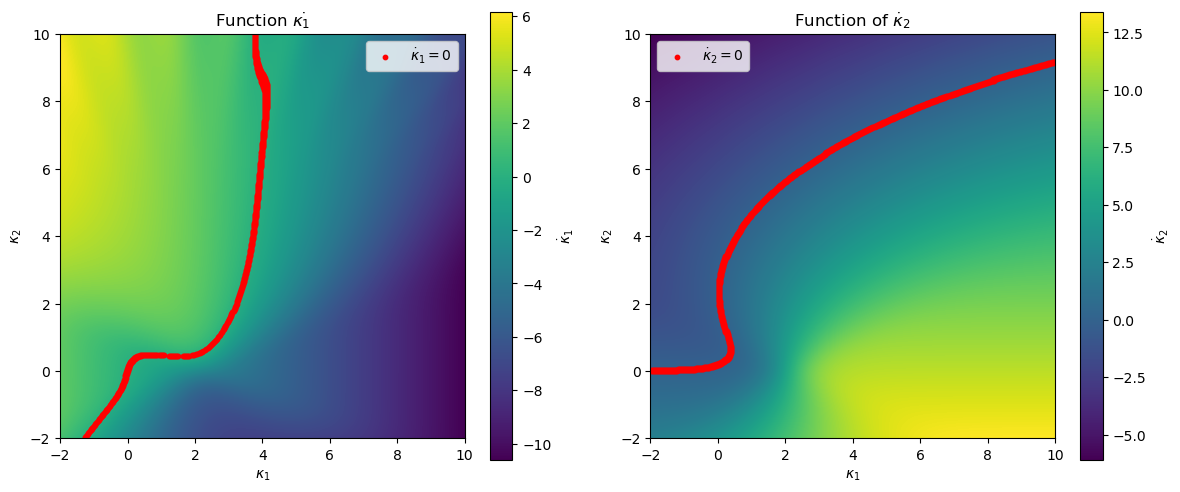

In [59]:
# 绘制\dot{\kappa_1}的heatmap
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(kappa1_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis')
plt.colorbar(label='$\\dot{\\kappa}_1$')
plt.xlabel('$\\kappa_1$')
plt.ylabel('$\\kappa_2$')
plt.title('Function $\dot{\kappa_1}$')

# 标记\dot{\kappa_1}=0的格点
kappa1_zero = np.where(np.abs(kappa1_dot_grid) < 0.03)
plt.scatter(kappa1_grid[kappa1_zero], kappa2_grid[kappa1_zero], color='red', s=10, label='$\\dot{\kappa}_1=0$')
plt.legend()

# 绘制\dot{\kappa_2}的heatmap
plt.subplot(1, 2, 2)
plt.imshow(kappa2_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis')
plt.colorbar(label='$\\dot{\\kappa}_2$')
plt.xlabel('$\\kappa_1$')
plt.ylabel('$\\kappa_2$')
plt.title('Function of $\\dot{\\kappa}_2$')

# 标记\dot{\kappa_2}=0的格点
kappa2_zero = np.where(np.abs(kappa2_dot_grid) < 0.03)
plt.scatter(kappa1_grid[kappa2_zero], kappa2_grid[kappa2_zero], color='red', s=10, label='$\\dot{\\kappa}_2=0$')
plt.legend()

plt.tight_layout()
plt.savefig(f'./nullcline_results_250915/kappa_dot_heatmaps_g{g}_j{j0}_tauc{tauc}.png')
plt.show()

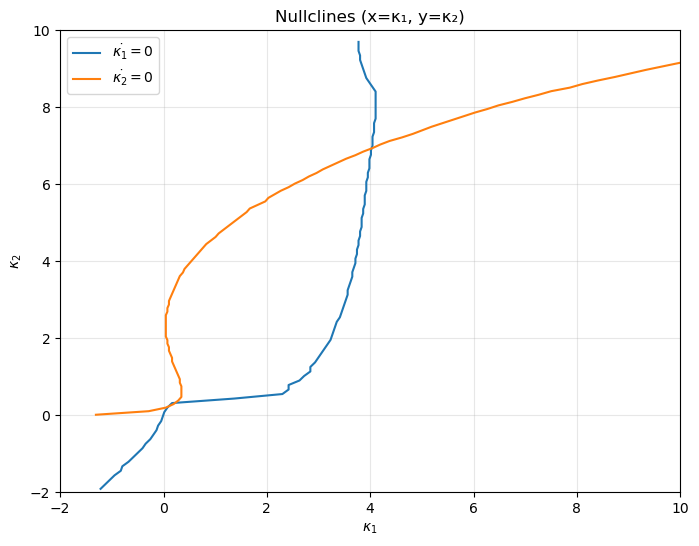

In [60]:
# 准备数据用于拟合曲线（以-κ2为自变量x，κ1为因变量y进行插值）
kappa1_vals = kappa1_grid.flatten()
kappa2_vals = kappa2_grid.flatten()
x_vals = -kappa2_vals  # 自变量x = -κ2
y_vals = kappa1_vals   # 因变量y = κ1

kappa1_dot_vals = kappa1_dot_grid.flatten()
kappa2_dot_vals = kappa2_dot_grid.flatten()

# 筛选\dot{\kappa_1}=0附近的数据点
kappa1_zero_points = np.column_stack((
    x_vals[np.abs(kappa1_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa1_dot_vals) < 0.01]   # y = κ1
))

# 筛选\dot{\kappa_2}=0附近的数据点
kappa2_zero_points = np.column_stack((
    x_vals[np.abs(kappa2_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa2_dot_vals) < 0.01]   # y = κ1
))

# 对\dot{\kappa_1}=0的数据点进行排序并拟合曲线
if len(kappa1_zero_points) > 0:
    kappa1_zero_points = kappa1_zero_points[np.argsort(kappa1_zero_points[:, 0])]
    kappa1_zero_curve_x_interp = np.linspace(
        kappa1_zero_points[:, 0].min(), 
        kappa1_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa1_zero_curve_y_interp = griddata(
        kappa1_zero_points[:, 0].reshape(-1, 1), 
        kappa1_zero_points[:, 1], 
        kappa1_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa1_nullcline_k1 = kappa1_zero_curve_y_interp  # κ1作为x轴
    kappa1_nullcline_k2 = -kappa1_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ1零倾线点")
    kappa1_nullcline_k1, kappa1_nullcline_k2 = [], []

# 对\dot{\kappa_2}=0的数据点进行排序并拟合曲线
if len(kappa2_zero_points) > 0:
    kappa2_zero_points = kappa2_zero_points[np.argsort(kappa2_zero_points[:, 0])]
    kappa2_zero_curve_x_interp = np.linspace(
        kappa2_zero_points[:, 0].min(), 
        kappa2_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa2_zero_curve_y_interp = griddata(
        kappa2_zero_points[:, 0].reshape(-1, 1), 
        kappa2_zero_points[:, 1], 
        kappa2_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa2_nullcline_k1 = kappa2_zero_curve_y_interp  # κ1作为x轴
    kappa2_nullcline_k2 = -kappa2_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ2零倾线点")
    kappa2_nullcline_k1, kappa2_nullcline_k2 = [], []

# 绘制拟合后的零倾线（以κ1为x轴，κ2为y轴）
plt.figure(figsize=(8, 6))
plt.plot(kappa1_nullcline_k1, kappa1_nullcline_k2, label=r'$\dot{\kappa_1}=0$')
plt.plot(kappa2_nullcline_k1, kappa2_nullcline_k2, label=r'$\dot{\kappa_2}=0$')
plt.xlabel(r'$\kappa_1$')  # x轴为κ1
plt.ylabel(r'$\kappa_2$')  # y轴为κ2
plt.title('Nullclines (x=κ₁, y=κ₂)')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'./nullcline_results_250915/nullcline_g{g}_j{j0}_tauc{tauc}.png')
plt.show()

In [61]:
# 定义参数
sigma = 0.45
N = 800
tauc = 0.250
g = 3.5
j0 = 0.003
N_E = 600
N_I = 200
thres = 2.1
bias = 1.0

In [62]:
# 生成网格
kappa1_range = np.linspace(-2, 10, 400)
kappa2_range = np.linspace(-2, 10, 400)
kappa1_grid, kappa2_grid = np.meshgrid(kappa1_range, kappa2_range)

# 计算\dot{\kappa_1}和\dot{\kappa_2}的网格值
kappa1_dot_grid = np.zeros_like(kappa1_grid)
kappa2_dot_grid = np.zeros_like(kappa2_grid)
for i in range(len(kappa1_range)):
    for j in range(len(kappa2_range)):
        kappa1_dot_grid[j, i] = kappa1_dot(kappa1_grid[j, i], kappa2_grid[j, i])
        kappa2_dot_grid[j, i] = kappa2_dot(kappa1_grid[j, i], kappa2_grid[j, i])

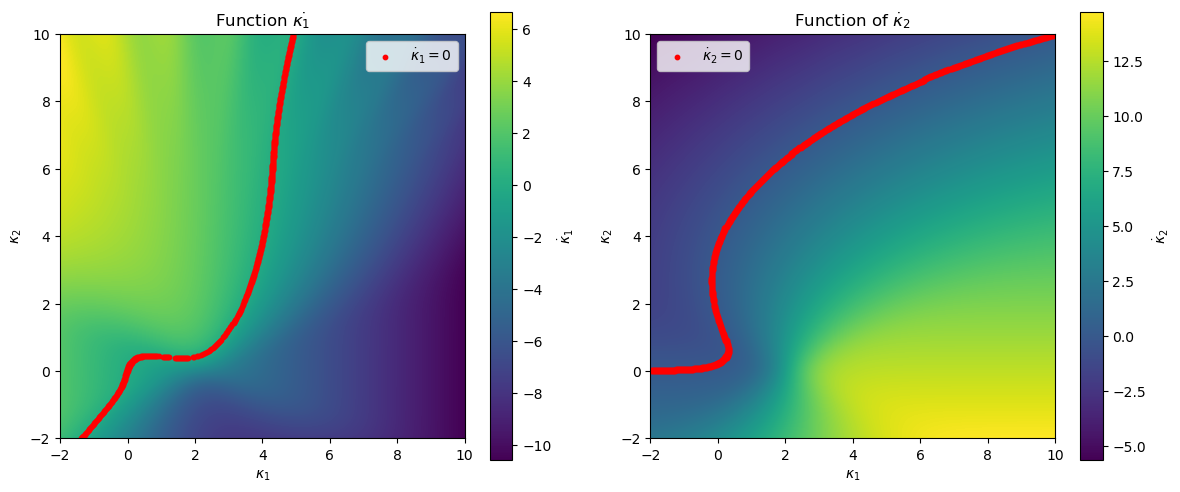

In [63]:
# 绘制\dot{\kappa_1}的heatmap
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(kappa1_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis')
plt.colorbar(label='$\\dot{\\kappa}_1$')
plt.xlabel('$\\kappa_1$')
plt.ylabel('$\\kappa_2$')
plt.title('Function $\dot{\kappa_1}$')

# 标记\dot{\kappa_1}=0的格点
kappa1_zero = np.where(np.abs(kappa1_dot_grid) < 0.03)
plt.scatter(kappa1_grid[kappa1_zero], kappa2_grid[kappa1_zero], color='red', s=10, label='$\\dot{\kappa}_1=0$')
plt.legend()

# 绘制\dot{\kappa_2}的heatmap
plt.subplot(1, 2, 2)
plt.imshow(kappa2_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis')
plt.colorbar(label='$\\dot{\\kappa}_2$')
plt.xlabel('$\\kappa_1$')
plt.ylabel('$\\kappa_2$')
plt.title('Function of $\\dot{\\kappa}_2$')

# 标记\dot{\kappa_2}=0的格点
kappa2_zero = np.where(np.abs(kappa2_dot_grid) < 0.03)
plt.scatter(kappa1_grid[kappa2_zero], kappa2_grid[kappa2_zero], color='red', s=10, label='$\\dot{\\kappa}_2=0$')
plt.legend()

plt.tight_layout()
plt.savefig(f'./nullcline_results_250915/kappa_dot_heatmaps_g{g}_j{j0}_tauc{tauc}.png')
plt.show()

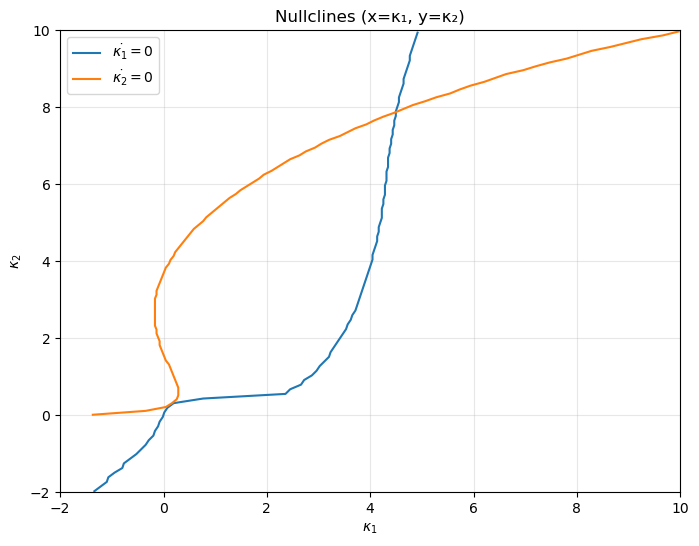

In [64]:
# 准备数据用于拟合曲线（以-κ2为自变量x，κ1为因变量y进行插值）
kappa1_vals = kappa1_grid.flatten()
kappa2_vals = kappa2_grid.flatten()
x_vals = -kappa2_vals  # 自变量x = -κ2
y_vals = kappa1_vals   # 因变量y = κ1

kappa1_dot_vals = kappa1_dot_grid.flatten()
kappa2_dot_vals = kappa2_dot_grid.flatten()

# 筛选\dot{\kappa_1}=0附近的数据点
kappa1_zero_points = np.column_stack((
    x_vals[np.abs(kappa1_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa1_dot_vals) < 0.01]   # y = κ1
))

# 筛选\dot{\kappa_2}=0附近的数据点
kappa2_zero_points = np.column_stack((
    x_vals[np.abs(kappa2_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa2_dot_vals) < 0.01]   # y = κ1
))

# 对\dot{\kappa_1}=0的数据点进行排序并拟合曲线
if len(kappa1_zero_points) > 0:
    kappa1_zero_points = kappa1_zero_points[np.argsort(kappa1_zero_points[:, 0])]
    kappa1_zero_curve_x_interp = np.linspace(
        kappa1_zero_points[:, 0].min(), 
        kappa1_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa1_zero_curve_y_interp = griddata(
        kappa1_zero_points[:, 0].reshape(-1, 1), 
        kappa1_zero_points[:, 1], 
        kappa1_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa1_nullcline_k1 = kappa1_zero_curve_y_interp  # κ1作为x轴
    kappa1_nullcline_k2 = -kappa1_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ1零倾线点")
    kappa1_nullcline_k1, kappa1_nullcline_k2 = [], []

# 对\dot{\kappa_2}=0的数据点进行排序并拟合曲线
if len(kappa2_zero_points) > 0:
    kappa2_zero_points = kappa2_zero_points[np.argsort(kappa2_zero_points[:, 0])]
    kappa2_zero_curve_x_interp = np.linspace(
        kappa2_zero_points[:, 0].min(), 
        kappa2_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa2_zero_curve_y_interp = griddata(
        kappa2_zero_points[:, 0].reshape(-1, 1), 
        kappa2_zero_points[:, 1], 
        kappa2_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa2_nullcline_k1 = kappa2_zero_curve_y_interp  # κ1作为x轴
    kappa2_nullcline_k2 = -kappa2_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ2零倾线点")
    kappa2_nullcline_k1, kappa2_nullcline_k2 = [], []

# 绘制拟合后的零倾线（以κ1为x轴，κ2为y轴）
plt.figure(figsize=(8, 6))
plt.plot(kappa1_nullcline_k1, kappa1_nullcline_k2, label=r'$\dot{\kappa_1}=0$')
plt.plot(kappa2_nullcline_k1, kappa2_nullcline_k2, label=r'$\dot{\kappa_2}=0$')
plt.xlabel(r'$\kappa_1$')  # x轴为κ1
plt.ylabel(r'$\kappa_2$')  # y轴为κ2
plt.title('Nullclines (x=κ₁, y=κ₂)')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'./nullcline_results_250915/nullcline_g{g}_j{j0}_tauc{tauc}.png')
plt.show()

In [65]:
# 定义参数
sigma = 0.45
N = 800
tauc = 0.300
g = 3.5
j0 = 0.003
N_E = 600
N_I = 200
thres = 2.1
bias = 1.0

In [66]:
# 生成网格
kappa1_range = np.linspace(-2, 10, 400)
kappa2_range = np.linspace(-2, 10, 400)
kappa1_grid, kappa2_grid = np.meshgrid(kappa1_range, kappa2_range)

# 计算\dot{\kappa_1}和\dot{\kappa_2}的网格值
kappa1_dot_grid = np.zeros_like(kappa1_grid)
kappa2_dot_grid = np.zeros_like(kappa2_grid)
for i in range(len(kappa1_range)):
    for j in range(len(kappa2_range)):
        kappa1_dot_grid[j, i] = kappa1_dot(kappa1_grid[j, i], kappa2_grid[j, i])
        kappa2_dot_grid[j, i] = kappa2_dot(kappa1_grid[j, i], kappa2_grid[j, i])

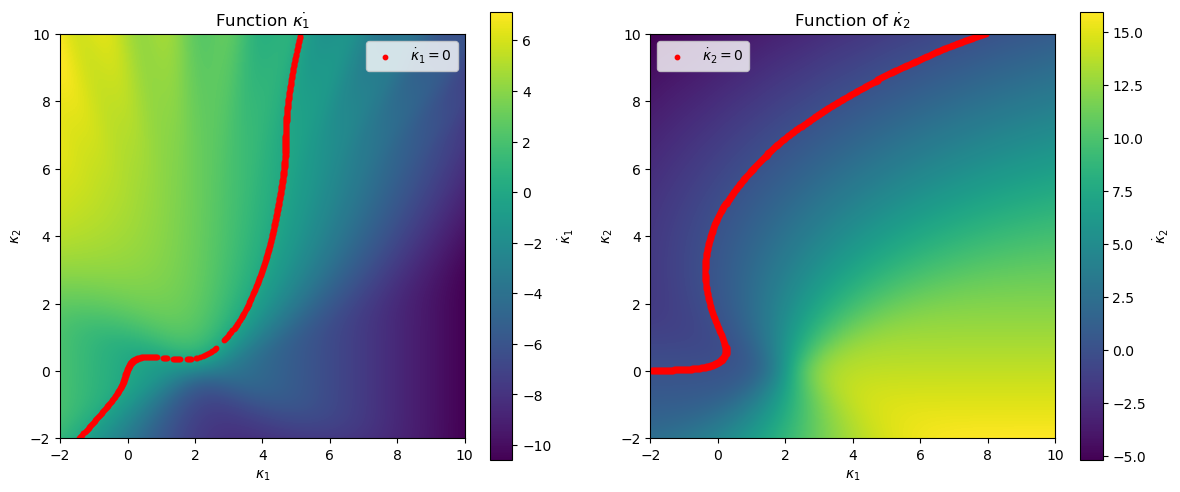

In [67]:
# 绘制\dot{\kappa_1}的heatmap
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(kappa1_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis')
plt.colorbar(label='$\\dot{\\kappa}_1$')
plt.xlabel('$\\kappa_1$')
plt.ylabel('$\\kappa_2$')
plt.title('Function $\dot{\kappa_1}$')

# 标记\dot{\kappa_1}=0的格点
kappa1_zero = np.where(np.abs(kappa1_dot_grid) < 0.03)
plt.scatter(kappa1_grid[kappa1_zero], kappa2_grid[kappa1_zero], color='red', s=10, label='$\\dot{\kappa}_1=0$')
plt.legend()

# 绘制\dot{\kappa_2}的heatmap
plt.subplot(1, 2, 2)
plt.imshow(kappa2_dot_grid, extent=[-2, 10, -2, 10], origin='lower', cmap='viridis')
plt.colorbar(label='$\\dot{\\kappa}_2$')
plt.xlabel('$\\kappa_1$')
plt.ylabel('$\\kappa_2$')
plt.title('Function of $\\dot{\\kappa}_2$')

# 标记\dot{\kappa_2}=0的格点
kappa2_zero = np.where(np.abs(kappa2_dot_grid) < 0.03)
plt.scatter(kappa1_grid[kappa2_zero], kappa2_grid[kappa2_zero], color='red', s=10, label='$\\dot{\\kappa}_2=0$')
plt.legend()

plt.tight_layout()
plt.savefig(f'./nullcline_results_250915/kappa_dot_heatmaps_g{g}_j{j0}_tauc{tauc}.png')
plt.show()

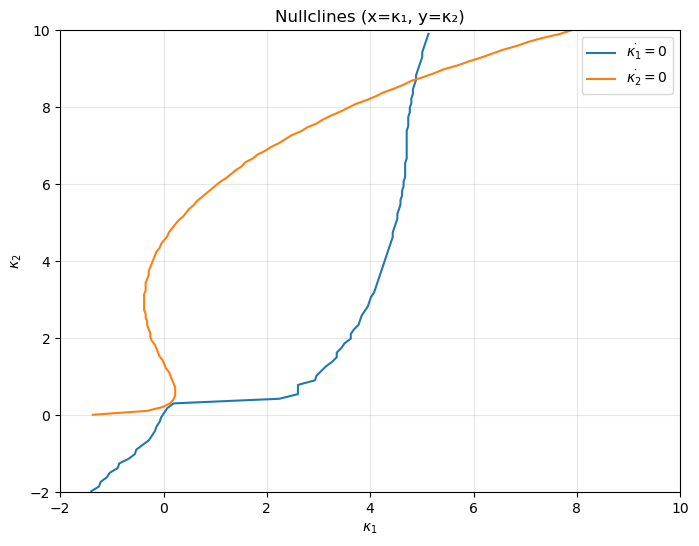

In [68]:
# 准备数据用于拟合曲线（以-κ2为自变量x，κ1为因变量y进行插值）
kappa1_vals = kappa1_grid.flatten()
kappa2_vals = kappa2_grid.flatten()
x_vals = -kappa2_vals  # 自变量x = -κ2
y_vals = kappa1_vals   # 因变量y = κ1

kappa1_dot_vals = kappa1_dot_grid.flatten()
kappa2_dot_vals = kappa2_dot_grid.flatten()

# 筛选\dot{\kappa_1}=0附近的数据点
kappa1_zero_points = np.column_stack((
    x_vals[np.abs(kappa1_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa1_dot_vals) < 0.01]   # y = κ1
))

# 筛选\dot{\kappa_2}=0附近的数据点
kappa2_zero_points = np.column_stack((
    x_vals[np.abs(kappa2_dot_vals) < 0.01],  # x = -κ2
    y_vals[np.abs(kappa2_dot_vals) < 0.01]   # y = κ1
))

# 对\dot{\kappa_1}=0的数据点进行排序并拟合曲线
if len(kappa1_zero_points) > 0:
    kappa1_zero_points = kappa1_zero_points[np.argsort(kappa1_zero_points[:, 0])]
    kappa1_zero_curve_x_interp = np.linspace(
        kappa1_zero_points[:, 0].min(), 
        kappa1_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa1_zero_curve_y_interp = griddata(
        kappa1_zero_points[:, 0].reshape(-1, 1), 
        kappa1_zero_points[:, 1], 
        kappa1_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa1_nullcline_k1 = kappa1_zero_curve_y_interp  # κ1作为x轴
    kappa1_nullcline_k2 = -kappa1_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ1零倾线点")
    kappa1_nullcline_k1, kappa1_nullcline_k2 = [], []

# 对\dot{\kappa_2}=0的数据点进行排序并拟合曲线
if len(kappa2_zero_points) > 0:
    kappa2_zero_points = kappa2_zero_points[np.argsort(kappa2_zero_points[:, 0])]
    kappa2_zero_curve_x_interp = np.linspace(
        kappa2_zero_points[:, 0].min(), 
        kappa2_zero_points[:, 0].max(), 
        100
    )
    # 插值得到κ1值
    kappa2_zero_curve_y_interp = griddata(
        kappa2_zero_points[:, 0].reshape(-1, 1), 
        kappa2_zero_points[:, 1], 
        kappa2_zero_curve_x_interp, 
        method='nearest'
    )
    # 转换回(κ1, κ2)坐标用于绘图
    kappa2_nullcline_k1 = kappa2_zero_curve_y_interp  # κ1作为x轴
    kappa2_nullcline_k2 = -kappa2_zero_curve_x_interp  # κ2作为y轴（-x）
else:
    print("未找到足够的κ2零倾线点")
    kappa2_nullcline_k1, kappa2_nullcline_k2 = [], []

# 绘制拟合后的零倾线（以κ1为x轴，κ2为y轴）
plt.figure(figsize=(8, 6))
plt.plot(kappa1_nullcline_k1, kappa1_nullcline_k2, label=r'$\dot{\kappa_1}=0$')
plt.plot(kappa2_nullcline_k1, kappa2_nullcline_k2, label=r'$\dot{\kappa_2}=0$')
plt.xlabel(r'$\kappa_1$')  # x轴为κ1
plt.ylabel(r'$\kappa_2$')  # y轴为κ2
plt.title('Nullclines (x=κ₁, y=κ₂)')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'./nullcline_results_250915/nullcline_g{g}_j{j0}_tauc{tauc}.png')
plt.show()